# ACIT5900: Master Thesis
### *System Architecture*

>-------------------------------------------
> *Spring 2025*

>--------------------------------------------

<a id="top"></a>
1. [**Preprocessing of Data**](#processing)<br>
    1.1 [**Load Data and Models**](#load) <br>
    1.2 [**Split Documents**](#split) <br>
    1.3 [**Create Vector Database**](#database) <br>
    1.4 [**Topic Modeling**](#topic-modeling) <br>
2. [**Evaluation of Summarization Generation**](#generation)<br>
    2.1 [**Generate Document Summaries**](#generate-summaries) <br>
    2.2 [**Compare Generated Summaries with Original Abstract**](#comparison) <br>
    2.3 [**Optimize LLM Parameters with Grid Search**](#grid-search1) <br>
    2.4 [**Apply Best Parameters and Evaluate Summaries**](#best-params) <br>
    2.5 [**Print Example Summary**](#example1) <br>
3. [**Evaluation of Summarization Refinement**](#refinement)<br>
    3.1 [**Iterative Refinement Using an LLM Judge**](#llm-judge) <br>
    3.2 [**Grid Search and Evaluation of Refinement Parameters**](#grid-search2) <br>
    3.3 [**Final Evaluation and Summary Refinement per Model**](#final-eval) <br>
    3.4 [**Signififance Testing**](#llm-significance) <br>
    3.5 [**Shuffle Abstracts**](#shuffle) <br>
4. [**Hallucination Detection**](#hallucination) <br>
    4.1 [**Sentence Processing**](#sentence-processing) <br>
    4.2 [**Compute Similarities and Thresholds**](#similarities) <br>
    4.3 [**Identify Hallucinations in Generated Summaries**](#identify-hallucinations) <br>
    4.4 [**Multi-Article Detection and Visualization**](#multi-article-detection) <br>
    4.5 [**Overall Hallucination Trends**](#trends) <br>
5. [**Hallucination Case Study**](#case-study) <br>
    5.1 [**Load and Process Dataset**](#load-process) <br>
    5.2 [**Max Cosine Similarity for Sentence-Level Detection**](#max-cosine) <br>
    5.3 [**Sentence-Level Comparison Against Ground Truth**](#comparison2) <br>
    5.4 [**Summary-Level Evaluation**](#summary-eval) <br>
    5.5 [**Sentence Classification and Visualization**](#classification-visuals) <br>

In [1]:
# remove old Chroma db before new run
!rm -rf chroma_db

In [1]:
# install dependencies
!pip install langchain langchain-chroma langchain-community chromadb bertopic bert-score langchain-huggingface jedi

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [3]:
# general utilities
import re
import json
import torch
import random
import difflib
import textwrap
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
from collections import defaultdict

# NLP resources
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# modeling and evaluation
from bert_score import score
from bertopic import BERTopic
from scipy.signal import argrelextrema
from scipy.stats import wilcoxon, gaussian_kde
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# clustering and dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

# LangChain components
from langchain.chains import RetrievalQA
from langchain_chroma import Chroma
from langchain.prompts import PromptTemplate
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from transformers import logging
logging.set_verbosity_error()

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
set_seed(42)

## <a id="processing"></a> 1) Preprocessing of Data

### <a id="load"></a> 1.1) Load Data and Models

This section initializes the data and models required for the pipeline. It starts by loading a pre-cleaned dataset from a CSV file using `pandas`. Next, it authenticates with the Hugging Face Hub to access pretrained language models. A dictionary of available models is defined, and one model is selected for use. The corresponding tokenizer and language model are then loaded, with the model configured to use the end-of-sequence (`eos_token`) as its padding token.

Additionally, a separate embedding model, `"all-MiniLM-L6-v2"`, is loaded to generate dense vector representations of text. These embeddings will be used for tasks such as information retrieval.

[⬆️ Back to Top](#top)


In [ ]:
file_path = '/content/df_cleaned.csv'

# read data frame
df = pd.read_csv(file_path)
df.head()

,title,authors,year_published,number,volume,journal,type,content,doi,file,abstract,cleaned_content,cleaned_abstract,cleaned_authors
0,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,missing,missing,missing,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28,"—Securing and managing large, complex enterpri...",Advanced Passive Operating System Fingerprinti...,"—Securing and managing large, complex enterpri...","['Desta Haileselassie Hagos', 'Martin Løland',..."
1,Artificial intelligence in the fertility clini...,"Riegler, M A and Stensen, M H and Witczak, O a...",2021,9.0,36,Human Reproduction,article,.................................................,10.1093/humrep/deab168,doc14,": In recent years, the amount of data produced...",.................................................,": In recent years, the amount of data produced...","['M A Riegler', 'M H Stensen', 'O Witczak', 'J..."
2,EvoDynamic: A Framework for the Evolution of G...,"Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz...",2020,missing,missing,missing,inproceedings,EvoDynamic: a framework for the evolution of\n...,missing,doc10,. Dynamical systems possess a computational ca...,EvoDynamic: a framework for the evolution of g...,. Dynamical systems possess a computational ca...,"['Sidney Pontes-Filho', 'Pedro Lind', 'Anis Ya..."
3,A general representation of dynamical systems ...,Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...,2019,missing,abs/1907.01856,CoRR,article,A general representation of dynamical systems ...,missing,doc11,—Dynamical systems are capable of performing c...,A general representation of dynamical systems ...,—Dynamical systems are capable of performing c...,"['Sidney Pontes-Filho', 'Anis Yazidi', 'Jianhu..."
4,Exploring Multilingual Word Embedding Alignmen...,"Aaby, Pernille\nand Biermann, Daniel\nand Yazi...",2023,missing,missing,missing,inproceedings,"\n \n \n \nAccepted manuscript \nAaby, P., Bi...",missing,doc12,". Contextual language models, such as transfor...","Accepted manuscript Aaby, P., Biermann, D., Ya...",". Contextual language models, such as transfor...","['Pernille Aaby', 'Daniel Biermann', 'Anis Yaz..."


In [8]:
from huggingface_hub import login
login()

In [9]:
# define available models
available_models = {
    "Llama3": "meta-llama/Llama-3.2-1B-Instruct",
    "Falcon3": "tiiuae/Falcon3-1B-Instruct",
    "Granite": "ibm-granite/granite-3.0-1b-a400m-instruct"
}

# choose model
selected_model = available_models["Llama3"]

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(selected_model)
llm_model = AutoModelForCausalLM.from_pretrained(selected_model)
llm_model.config.pad_token_id = tokenizer.eos_token_id

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
llm_model = llm_model.to(device)

In [10]:
# load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

### <a id="split"></a> 1.2) Split Documents

This section prepares the dataset for downstream retrieval and semantic analysis by converting each row in the dataframe into a structured LangChain `Document` object. Each document includes the main text content as well as rich metadata such as the title, file name, authors, abstract, and publication year.

To enable efficient processing and retrieval, each document is then split into smaller overlapping text chunks using a recursive character-based text splitter. The number of chunks is tracked per document and logged for inspection. These chunks serve as the basic units for later embedding, indexing, and retrieval tasks.

[⬆️ Back to Top](#top)


In [11]:
# convert each row into a langchain document
documents = [
    Document(page_content=row["cleaned_content"], metadata={"title": row["title"], "authors": row["authors"], "file": row["file"], "year_published": row["year_published"], "abstract": row["abstract"]})
    for _, row in df.iterrows()
]

In [12]:
def split_documents(documents, chunk_size=500, chunk_overlap=50):
    """
    Splits list of documents into smaller chunks for easier processing.

    Args:
        documents: list of documents to be split into chunks.
        chunk_size: maximum size of each chunk in characters.
        chunk_overlap: number of overlapping characters between consecutive chunks.

    Returns:
        tuple: containing chunks of text chunks after splitting and chunk_counts for dictionary with
        count of chunks per document, using file name as key.
    """
    # initialize a character-based splitter with set separators
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )

    chunks = []
    chunk_counts = {}

    for doc in documents:

        # split each document into chunks
        doc_chunks = text_splitter.split_documents([doc])

        # record the number of chunks for this document using its filename
        chunk_counts[doc.metadata["file"]] = len(doc_chunks)

        for chunk in doc_chunks:

            # ensure file metadata is carried over to each chunk
            chunk.metadata["file"] = doc.metadata["file"]
            chunks.append(chunk)

    print(f"Total chunks created: {len(chunks)} \n")
    return chunks, chunk_counts

chunked_documents, chunk_counts = split_documents(documents)

Total chunks created: 1969 



In [13]:
# display chunking info for a few documents
for doc in documents[:4]:
    num_chunks = chunk_counts.get(doc.metadata["file"], 0)
    print(f"File: {doc.metadata['file']}")
    print(f"Original document length: {len(doc.page_content)}")
    print(f"Number of chunks: {num_chunks}\n")

File: doc28
Original document length: 66818
Number of chunks: 149

File: doc14
Original document length: 68223
Number of chunks: 153

File: doc10
Original document length: 34247
Number of chunks: 77

File: doc11
Original document length: 22320
Number of chunks: 50



### <a id="database"></a> 1.3) Create Vector Database

This section creates and manages a vector database for efficient document retrieval and topic modeling. First, the chunked documents are embedded using a sentence transformer and stored in a Chroma vector database. The database is then validated to ensure all chunks are properly indexed. To analyze the high-dimensional embeddings, dimensionality reduction techniques like PCA and T-SNE are applied, followed by KMeans clustering to identify latent groupings. For topic modeling, both LDA and BERTopic are used to extract and visualize key themes across the documents, enabling better understanding of the dataset's structure and content distribution.


[⬆️ Back to Top](#top)

In [14]:
# create Chroma vector database
vectorstore = Chroma.from_documents(documents=chunked_documents, embedding=embedding_model, persist_directory="chroma_db")

In [15]:
# load existing Chroma vector database
vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_model)

# define retriever
retriever = vectorstore.as_retriever()

In [16]:
# check the number of documents stored in ChromaDB
stored_count = vectorstore._collection.count()
expected_count = len(chunked_documents)

print(f"Stored documents in ChromaDB: {stored_count}")
print(f"Expected text splits: {expected_count}")

# validate indexing success
if stored_count == expected_count:
    print("All text splits are correctly stored in ChromaDB.")
else:
    print(f"Mismatch detected: {expected_count - stored_count} documents missing.")
    print("Some documents might not have been indexed properly.")


Stored documents in ChromaDB: 1969
Expected text splits: 1969
All text splits are correctly stored in ChromaDB.


In [17]:
# load embeddings from Chroma
embeddings = vectorstore._collection.get(include=['embeddings'])['embeddings']
document_embeddings = np.array(embeddings)

# reduce dimensions with PCA to speed up TSNE
pca = PCA(n_components=50)
pca_embeddings = pca.fit_transform(document_embeddings)

In [18]:
# apply T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

# apply KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels_tsne = kmeans.fit_predict(tsne_embeddings)

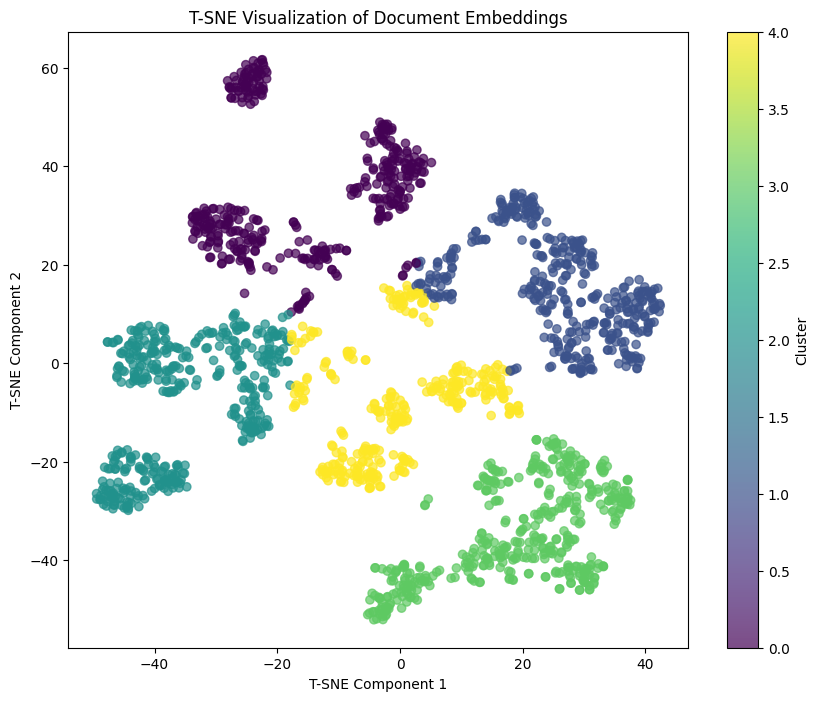

In [19]:
# plot T-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels_tsne, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("T-SNE Visualization of Document Embeddings")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.show()

### <a id="topic-modeling"></a> 1.4) Topic Modeling

This section applies topic modeling to the document collection using the BERTopic framework. The process begins by preprocessing each document: text is lowercased, tokenized, stripped of English stopwords, and lemmatized using NLTK. These preprocessed texts are then used to train a BERTopic model, which clusters documents based on semantic similarity and extracts interpretable topics.

After fitting the model, a summary of discovered topics is retrieved, and a bar chart is generated to visualize the most prominent themes. This helps in understanding the dominant topics within the dataset and provides insights into its semantic structure.

[⬆️ Back to Top](#top)

In [20]:
def preprocess_text(text):
    """
    Preprocesses the input text by tokenizing, removing stopwords, and lemmatizing.

    Args:
        text: The input text to be preprocessed.

    Returns:
        str: The preprocessed text as a space-separated string of lemmatized tokens.
    """

    # tokenize text
    tokens = nltk.word_tokenize(text.lower())

    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [21]:
# extract text documents
documents = vectorstore._collection.get(include=['documents'])['documents']

# apply preprocessing to each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# initialize BERTopic
topic_model = BERTopic()

# fit model on preprocessed documents
topics, probs = topic_model.fit_transform(preprocessed_documents)

# get topic info
topic_info = topic_model.get_topic_info()

# visualize the topics
topic_model.visualize_barchart(top_n_topics=8)

## <a id="generation"></a> 2) Evaluation of Summarization Generation

### <a id="generate-summaries"></a> 2.1) Generate Document Summaries

This section defines a function that generates summaries of research articles at two different levels of complexity: basic and specialized. The process begins by retrieving relevant documents based on the article title using a retrieval module. Two distinct prompts are then formulated: one designed for a general audience (basic) and another for domain experts (specialized). These prompts are passed through a retrieval-augmented QA chain to generate summaries tailored to each audience.

The function returns both the retrieved documents and the generated summaries, forming a foundation for later evaluation of how effectively the model adapts its output to different levels of technical understanding.

[⬆️ Back to Top](#top)


In [19]:
# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sentence embeddings
sim_model = SentenceTransformer("all-mpnet-base-v2")

In [20]:
def generate_summaries(title, retriever, qa_chain):
    """
    Retrieves relevant documents and generates two summaries (basic and specialized) for a research article.

    Args:
        title: The title of the article.
        retriever: The document retriever.
        qa_chain: The QA chain used to generate summaries.

    Returns:
        dict: A dictionary containing the retrieved documents and generated summaries at two levels.
    """

    # retrieve relevant documents based on the article title
    retrieved_docs = retriever.invoke(title)
    if not retrieved_docs:
        return {"retrieved_docs": [], "generated_summaries": {}}

    queries = {
    "basic": f"Provide a simple, non-technical summary of the research article titled '{title}'. Use clear language suitable for a general audience and avoid complex terminology, notes, or references.",
    "specialized": f"Provide a concise, technical summary of the research article titled '{title}', using domain-specific language appropriate for experts. Do not include additional notes, comments, or references."
    }

    summaries = {}

    # generate summary for each level
    for level, query in queries.items():

        # invoke QA chain with current query and retrieved documents
        response = qa_chain.invoke(input={"query": query, "documents": retrieved_docs})

        # extract summary text from response
        summaries[level] = response.get("result", "").split("Answer:")[-1].strip()

    return {
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summaries": summaries,
    }

### <a id="comparison"></a> 2.2) Compare Generated Summaries with Original Abstract

This section evaluates the quality of generated summaries by comparing them to the original abstract of a research article. The process is structured into three main steps:

1. **Summary Retrieval**: The `abstract_summary_comparison` function retrieves the original abstract, relevant context documents, and the model-generated summaries (basic and specialized) for a given article.

2. **Automated Evaluation**: Each summary is evaluated using sentence embeddings to compute cosine similarity against two targets:
   - The original abstract, to measure **faithfulness** (semantic alignment).
   - The full retrieved context, to measure **context precision** (relevance to source material).

3. **Metric Reporting**: The `final_summary_evaluation` function combines these scores into a dictionary of evaluation metrics for each summary. This allows comparison of how well each summary preserves meaning and adheres to the retrieved documents.

[⬆️ Back to Top](#top)


In [21]:
def compute_cosine(text1, text2, model):
    """
    Computes the cosine similarity between two texts using the given model.

    Args:
        text1: The first text to compare.
        text2: The second text to compare.
        model: The embedding model used to generate text embeddings.

    Returns:
        float: The cosine similarity between the two texts.
    """
    embeddings = model.encode([text1, text2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

In [22]:
def evaluate_summary(summary, abstract, context, sim_model):
    """
    Compares a summary to the abstract and context to measure its quality.

    Args:
        summary: The summary to evaluate.
        abstract: The original abstract of the article.
        context: A list of context documents.
        sim_model: The model used to calculate similarity.

    Returns:
        dict: Similarity scores for faithfulness.
    """
    full_context = " ".join(context)
    return {
        "Faithfulness (Abstract Similarity)": compute_cosine(summary, abstract, sim_model),
    }

In [23]:
def abstract_summary_comparison(article_id, df, retriever, qa_chain, sim_model):
    """
    Compares the abstract with generated summaries for a given article.

    Args:
        article_id: The ID of the article in the DataFrame.
        df: The DataFrame containing article data.
        retriever: The document retriever.
        qa_chain: The QA chain for generating summaries.
        sim_model: The model for calculating similarity (though not used here).

    Returns:
        dict: A dictionary containing the article title, original abstract, retrieved documents,
        and generated summaries.
    """
    article = df.iloc[article_id]
    title, abstract = article["title"], article["abstract"]
    summary_data = generate_summaries(title, retriever, qa_chain)

    return {
        "title": title,
        "original_abstract": abstract,
        "retrieved_docs": summary_data["retrieved_docs"],
        "generated_summaries": summary_data["generated_summaries"]
    }

In [24]:
def final_summary_evaluation(article_id, df, retriever, qa_chain, sim_model):
    """
    Evaluates the generated summaries for an article by comparing them to the original abstract and context.

    Args:
        article_id: The ID of the article in the DataFrame.
        df: The DataFrame containing article data.
        retriever: The document retriever.
        qa_chain: The QA chain for generating summaries.
        sim_model: The model used to calculate similarity.

    Returns:
        dict: A dictionary with evaluation metrics for each generated summary.
    """

    # generate summaries and retrieve original abstract and supporting context
    comparison = abstract_summary_comparison(article_id, df, retriever, qa_chain, sim_model)
    original_abstract = comparison["original_abstract"]
    context = comparison["retrieved_docs"]
    evaluation_results = {}

    # evaluate each summary against abstract and retrieved context
    for level, summary in comparison["generated_summaries"].items():
        metrics = evaluate_summary(summary, original_abstract, context, sim_model)
        evaluation_results[level] = metrics

    return evaluation_results

### <a id="grid-search1"></a> 2.3) Optimize LLM Parameters with Grid Search

This section fine-tunes key generation parameters (maximum token length, temperature, and repetition penalty) to improve the quality of summaries produced by the language model. A grid search is used to evaluate multiple parameter combinations, scoring each configuration based on semantic similarity to the original abstract and supporting context. The best-performing configuration is saved for later use.

All combinations of selected hyperparameters are evaluated by generating both basic and specialized summaries for a set of articles. Each summary is compared to the original abstract and retrieved context using cosine similarity. The evaluation produces a joint score that reflects the balance between faithfulness and contextual relevance. The configuration with the highest joint score is selected as the best set of parameters.

[⬆️ Back to Top](#top)


In [ ]:
def grid_search_summary_evaluation(llm_model, tokenizer, retriever, df, sim_model, article_ids):
    """
    Runs a grid search over generation parameters to find the configuration that
    maximizes the average improvement from the basic to the specialized summary.

    Returns:
        dict: Best parameter combination based on average improvement.
    """

    # define parameter grid
    max_tokens_list = [600, 700]
    temperature_list = [0.5, 0.6, 0.7]
    repetition_penalty_list = [1.0, 1.2]

    results = []

    for max_tokens, temp, rep_penalty in product(max_tokens_list, temperature_list, repetition_penalty_list):
        print(f"\nEvaluating with max_tokens={max_tokens}, temperature={temp}, repetition_penalty={rep_penalty} ...")

        # create text generation pipeline
        llm_pipeline = pipeline(
            "text-generation",
            model=llm_model,
            tokenizer=tokenizer,
            max_new_tokens=max_tokens,
            temperature=temp,
            repetition_penalty=rep_penalty,
            device=0 if torch.cuda.is_available() else -1
        )
        llm = HuggingFacePipeline(pipeline=llm_pipeline)
        qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

        improvements = []

        for article_id in article_ids:
            eval_scores = final_summary_evaluation(article_id, df, retriever, qa_chain, sim_model)
            basic_score = eval_scores["basic"]["Faithfulness (Abstract Similarity)"]
            spec_score = eval_scores["specialized"]["Faithfulness (Abstract Similarity)"]
            improvements.append(spec_score - basic_score)

        avg_improvement = np.mean(improvements) if improvements else 0.0

        results.append({
            "max_tokens": max_tokens,
            "temperature": temp,
            "repetition_penalty": rep_penalty,
            "avg_improvement": avg_improvement
        })

    df_results = pd.DataFrame(results)
    best_idx = df_results["avg_improvement"].idxmax()
    best_params = df_results.loc[best_idx, ["max_tokens", "temperature", "repetition_penalty"]].to_dict()

    print("\nBest Parameters (by improvement):", best_params)

    return best_params


In [ ]:
def plot_all_articles_results(all_evaluations):
    """
    Plots faithfulness scores across articles for each summary type.

    Args:
        all_evaluations: List of evaluation dictionaries per article.

    Returns:
        None
    """
    summary_levels = ["basic", "specialized"]
    metric = "Faithfulness (Abstract Similarity)"

    plt.figure(figsize=(12, 6))
    for level in summary_levels:
        scores = [evaluation[level][metric] for evaluation in all_evaluations]
        plt.plot(range(len(all_evaluations)), scores, marker='o', label=f"{level.capitalize()} - {metric}")

    plt.xlabel("Article Index")
    plt.ylabel("Cosine Similarity")
    plt.title(f"{metric} Across Articles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# define list of articles to evaluate
article_ids = list(range(len(df)))

# run grid search to find best generation parameters based on average faithfulness
best_params = grid_search_summary_evaluation(
    llm_model=llm_model,
    tokenizer=tokenizer,
    retriever=retriever,
    df=df,
    sim_model=sim_model,
    article_ids=article_ids
)


Evaluating with max_tokens=600, temperature=0.5, repetition_penalty=1.0 ...

Evaluating with max_tokens=600, temperature=0.5, repetition_penalty=1.2 ...

Evaluating with max_tokens=600, temperature=0.6, repetition_penalty=1.0 ...

Evaluating with max_tokens=600, temperature=0.6, repetition_penalty=1.2 ...

Evaluating with max_tokens=600, temperature=0.7, repetition_penalty=1.0 ...

Evaluating with max_tokens=600, temperature=0.7, repetition_penalty=1.2 ...

Evaluating with max_tokens=700, temperature=0.5, repetition_penalty=1.0 ...

Evaluating with max_tokens=700, temperature=0.5, repetition_penalty=1.2 ...

Evaluating with max_tokens=700, temperature=0.6, repetition_penalty=1.0 ...

Evaluating with max_tokens=700, temperature=0.6, repetition_penalty=1.2 ...

Evaluating with max_tokens=700, temperature=0.7, repetition_penalty=1.0 ...

Evaluating with max_tokens=700, temperature=0.7, repetition_penalty=1.2 ...

✅ Best Parameters (by improvement): {'max_tokens': 700.0, 'temperature': 0.

### <a id="best-params"></a> 2.4) Apply Best Parameters and Evaluate Summaries

Using the best parameters, the QA pipeline is rebuilt and applied to the full dataset. Each article is re-evaluated to compute faithfulness and context precision scores. These results are plotted to visualize how well the model performs across all articles under the optimized settings.

[⬆️ Back to Top](#top)

In [ ]:
# create text-generation pipeline with best parameters
llm_pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    max_new_tokens=int(best_params["max_tokens"]), # max tokens to generate per response
    temperature=float(best_params["temperature"]), # controls creativity in generation
    repetition_penalty=float(best_params["repetition_penalty"]), # penalizes repeated phrases
    device=0 if torch.cuda.is_available() else -1
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

In [ ]:
all_evaluations = []

for article_id in article_ids:

    # evaluate summaries for current article using abstract and context
    eval_result = final_summary_evaluation(article_id, df, retriever, qa_chain, sim_model)
    all_evaluations.append(eval_result)

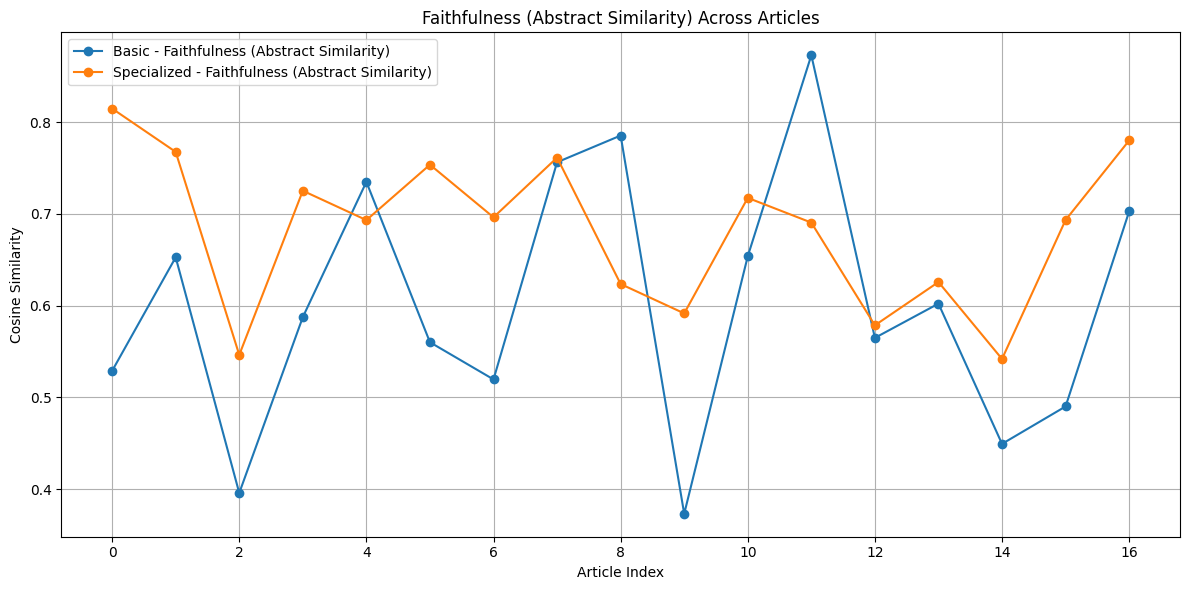

In [ ]:
plot_all_articles_results(all_evaluations)

### <a id="example1"></a> 2.5) Print Example Summary

Finally, an example article is selected to showcase the impact of the optimized parameters. The function prints the original abstract along with the generated basic and specialized summaries, each followed by its cosine similarity score relative to the abstract. This provides a qualitative and quantitative illustration of the model's performance.

[⬆️ Back to Top](#top)


In [ ]:
def print_example_summary_from_best_params(best_params, llm_model, tokenizer, retriever, df, sim_model, article_id):
    """
    Prints an example summary (basic and specialized) using the best hyperparameters,
    along with cosine similarity to the original abstract.

    Args:
        best_params: The best hyperparameter combination.
        llm_model: The LLM model.
        tokenizer: Tokenizer for the LLM.
        retriever: Document retriever.
        df: DataFrame with articles.
        sim_model: Sentence transformer for similarity evaluation.
        article_id: ID of the article to show (default: 0).
    """

    # set up text generation pipeline using best parameters
    llm_pipeline = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=tokenizer,
        max_new_tokens=int(best_params["max_tokens"]),
        temperature=float(best_params["temperature"]),
        repetition_penalty=float(best_params["repetition_penalty"]),
        device=0 if torch.cuda.is_available() else -1
    )

    llm = HuggingFacePipeline(pipeline=llm_pipeline)
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

    # generate summaries and retrieve the original abstract for comparison
    comparison = abstract_summary_comparison(article_id, df, retriever, qa_chain, sim_model)

    abstract = comparison["original_abstract"]
    basic_summary = comparison["generated_summaries"]["basic"]
    specialized_summary = comparison["generated_summaries"]["specialized"]

    # encode text into embeddings for cosine similarity computation
    abstract_vec = sim_model.encode([abstract])[0]
    basic_vec = sim_model.encode([basic_summary])[0]
    spec_vec = sim_model.encode([specialized_summary])[0]

    # compute cosine similarity to evaluate faithfulness
    sim_basic = cosine_similarity([basic_vec], [abstract_vec])[0][0]
    sim_spec = cosine_similarity([spec_vec], [abstract_vec])[0][0]

    # print results
    print("\n--- Example Summary Using Best Parameters ---")
    print(f"Title: {comparison['title']}\n")
    print("Original Abstract:\n", abstract, "\n")
    print(f"Generated Basic Summary (Cosine Similarity = {sim_basic:.4f}):\n{basic_summary}\n")
    print(f"Generated Specialized Summary (Cosine Similarity = {sim_spec:.4f}):\n{specialized_summary}")

In [ ]:
# print example of basic and specialized summaries for article ID using the best parameter combination
print_example_summary_from_best_params(
    best_params=best_params,
    llm_model=llm_model,
    tokenizer=tokenizer,
    retriever=retriever,
    df=df,
    sim_model=sim_model,
    article_id=3
)


--- Example Summary Using Best Parameters ---
Title: A general representation of dynamical systems for reservoir computing

Original Abstract:
 —Dynamical systems are capable of performing com-
putation in a reservoir computing paradigm. This paper presents
a general representation of these systems as an artiﬁcial neural
network (ANN). Initially, we implement the simplest dynamical
system, a cellular automaton. The mathematical fundamentals be-
hind an ANN are maintained, but the weights of the connections
and the activation function are adjusted to work as an update
rule in the context of cellular automata. The advantages of such
implementation are its usage on specialized and optimized deep
learning libraries, the capabilities to generalize it to other types of
networks and the possibility to evolve cellular automata and other
dynamical systems in terms of connectivity, update and learning
rules. Our implementation of cellular automata constitutes an
initial step towards a general f

## <a id="refinement"></a> 3) Evaluation of Summarization Refinement

### <a id="llm-judge"></a> 3.1) Iterative Refinement Using an LLM Judge

This section introduces an iterative approach where a large language model (LLM) acts as a judge to refine generated summaries. Starting from an initial basic summary, the LLM provides revisions intended to improve faithfulness to both the retrieved documents and the original abstract. Cosine similarity is used to evaluate each revision. A revised summary is only accepted if it achieves a higher similarity score, ensuring that refinement leads to progressively more aligned outputs.

[⬆️ Back to Top](#top)

In [36]:
def llm_judge(generated_summary, retrieved_docs, original_abstract, model, tokenizer,
              temperature, max_new_tokens, top_p, device='cuda'):
    """
    Uses an LLM to revise a generated summary, ensuring it aligns with retrieved documents
    and resembles a faithful academic abstract.

    Args:
        generated_summary: The initial summary to be revised.
        retrieved_docs: The supporting documents to use as factual reference.
        original_abstract: The article's original abstract (not used in revision, but could be logged).
        model: The language model for generation.
        tokenizer: Tokenizer for the model.
        temperature: Sampling temperature.
        max_new_tokens: Maximum number of tokens to generate.
        top_p: Nucleus sampling parameter.
        device: Device to run model on cuda or cpu.

    Returns:
        tuple: (rewritten summary, explanation)
    """

    # prompt instructions
    prompt = (
        "Revise the following summary so that it accurately reflects the key information from the retrieved documents."
        "Write the summary in a more advanced language and preserve important terminology from the documents.\n\n"
        "Write as a single, coherent paragraph with no bullet points or listing of concepts.\n\n"
        f"Retrieved Documents:\n{retrieved_docs}\n\n"
        f"Current Summary:\n{generated_summary}\n\n"
        "Rewritten Summary:"
    )

    # tokenize and prepare input for model
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(device)

    # generate rewritten summary with specified parameters
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        top_p=top_p,
        temperature=temperature,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

    # decode model output
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    # extract only rewritten summary text
    rewritten = explanation.split("Rewritten Summary:")[-1].strip()

    return rewritten, "Refined to align better with retrieved content and abstract structure."

In [37]:
def iterative_summary_refinement(article_id, df, retriever, qa_chain, model, tokenizer, sim_model,
                                 max_iterations, refinement_temperature, refinement_max_new_tokens,
                                 refinement_top_p):
    """
    Iteratively refines a generated summary using LLM feedback to improve its similarity to the original abstract.

    Args:
        article_id: Index of the article in the DataFrame.
        df: DataFrame containing articles with title and abstract.
        retriever: Document retriever to fetch relevant content.
        qa_chain: QA chain to generate the initial summary.
        model: LLM for rewriting summaries.
        tokenizer: Tokenizer for the LLM.
        sim_model: Sentence transformer for cosine similarity computation.
        max_iterations: Maximum number of refinement iterations.
        refinement_temperature: Temperature for summary generation.
        refinement_max_new_tokens: Max tokens allowed in revised summary.
        refinement_top_p: Top-p parameter.

    Returns:
        dict: Contains the article title, abstract, retrieved docs, summary versions,
        feedback history, and final summary.
    """

    device = next(model.parameters()).device

    # retrieve article title and abstract
    article = df.iloc[article_id]
    title = article["title"]
    original_abstract = article["abstract"]

    # generate initial summaries and retrieve relevant documents
    summary_data = generate_summaries(title, retriever, qa_chain)
    retrieved_docs = summary_data["retrieved_docs"]
    generated_summaries = {}

    # if no documents were retrieved, return early
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summaries": {},
            "feedback_history": [],
            "final_specialized_summary": "",
        }

    # start refinement with the basic summary
    current_summary = summary_data["generated_summaries"]["basic"]
    generated_summaries["basic"] = current_summary

    # encode original abstract for similarity comparison
    original_vector = sim_model.encode([original_abstract])[0]
    feedback_history = []

    for iteration in range(max_iterations):
        # ask LLM to revise summary using retrieved documents
        rewritten_summary, feedback = llm_judge(
              generated_summary=current_summary,
              retrieved_docs=retrieved_docs,
              original_abstract=original_abstract,
              model=model,
              tokenizer=tokenizer,
              temperature=refinement_temperature,
              max_new_tokens=refinement_max_new_tokens,
              top_p=refinement_top_p,
              device=device
        )

        feedback_history.append((f"refined_{iteration + 1}", feedback))

        # compute similarity of revised summary to original abstract
        current_vector = sim_model.encode([rewritten_summary])[0]
        current_similarity = cosine_similarity([original_vector], [current_vector])[0][0]

        # save revised summary
        generated_summaries[f"refined_iteration_{iteration + 1}"] = rewritten_summary

        # update current_summary to carry over improvements
        current_summary = rewritten_summary

    return {
        "title": title,
        "original_abstract": original_abstract,
        "retrieved_docs": retrieved_docs,
        "generated_summaries": generated_summaries,
        "feedback_history": feedback_history,
        "final_specialized_summary": current_summary,
    }


### <a id="grid-search2"></a> 3.2) Grid Search and Evaluation of Refinement Parameters

To tune the quality of LLM-based refinement, a grid search is conducted over parameters such as temperature, top-p sampling, and maximum token length. Each configuration is evaluated across multiple articles using cosine similarity between the final refined summary and the original abstract. The best configuration is selected based on average similarity, and the results are visualized to show how summary quality evolves across iterations.

[⬆️ Back to Top](#top)

In [38]:
def grid_search_for_model(df, retriever, qa_chain, model, tokenizer, sim_model, article_ids, device, max_iterations):
    """
    Runs a grid search to find the best generation parameters for iterative summary refinement based on cosine similarity improvement.

    Args:
        df: DataFrame of articles.
        retriever: Document retriever.
        qa_chain: Initial summary generator.
        model: LLM for refinement.
        tokenizer: Model tokenizer.
        sim_model: Embedding model for similarity scoring.
        article_ids: List of article indices.
        device: cuda or cpu.
        max_iterations: Max refinement steps per article.

    Returns:
        tuple: (best_params, data frame of parameter scores)
    """

    temperatures = [0.3]#, 0.4, 0.5]
    max_new_tokens_list = [250]#, 350]
    top_p_list = [0.90]#, 0.95]

    param_combinations = list(product(temperatures, max_new_tokens_list, top_p_list))
    results = []

    for temp, max_tokens, top_p in param_combinations:
        print(f"\nEvaluating with temperature={temp}, max_new_tokens={max_tokens}, top_p={top_p} ...")

        improvements = []

        for article_id in article_ids:
            result = iterative_summary_refinement(
                article_id, df, retriever, qa_chain, model, tokenizer, sim_model,
                max_iterations,
                refinement_temperature=temp,
                refinement_max_new_tokens=max_tokens,
                refinement_top_p=top_p
            )

            if result["generated_summaries"]:
                original_vector = sim_model.encode([result["original_abstract"]])[0]
                basic_summary = result["generated_summaries"]["basic"]
                final_summary = result["final_specialized_summary"]

                basic_vector = sim_model.encode([basic_summary])[0]
                final_vector = sim_model.encode([final_summary])[0]

                sim_basic = cosine_similarity([original_vector], [basic_vector])[0][0]
                sim_final = cosine_similarity([original_vector], [final_vector])[0][0]
                improvement = sim_final - sim_basic
                improvements.append(improvement)

        avg_improvement = np.mean(improvements) if improvements else 0.0

        results.append({
            "temperature": temp,
            "max_new_tokens": max_tokens,
            "top_p": top_p,
            "avg_improvement": avg_improvement
        })

    df_results = pd.DataFrame(results)
    best_idx = df_results["avg_improvement"].idxmax()
    best_params = df_results.loc[best_idx, ["temperature", "max_new_tokens", "top_p"]].to_dict()

    return best_params, df_results


In [39]:
# define available models
available_models = {
    "Llama3": "meta-llama/Llama-3.2-1B-Instruct",
    "Falcon3": "tiiuae/Falcon3-1B-Instruct",
    "Granite": "ibm-granite/granite-3.0-1b-a400m-instruct"
}

model_results = {}
best_configs_per_model = {}
all_grid_results = {}

# define articles to use for grid search and final evaluation
article_ids_for_grid_search = list(range(len(df)))
article_ids_for_final_run = list(range(len(df)))

In [ ]:
def evaluate_model_across_articles(model_name, llm_model, tokenizer, qa_chain, best_params, max_iterations):
    """
    Evaluates a model's summary refinement performance across all articles by tracking
    cosine similarity to the original abstract over iterations.

    Args:
        model_name: Identifier for the current model.
        llm_model: The language model used for refinement.
        tokenizer: The tokenizer for the model.
        qa_chain: QA chain for generating initial summaries.
        best_params: Best hyperparameters for this model from grid search.
        max_iterations: Maximum number of refinement iterations.

    Returns:
        dict: Mapping from article title to similarity scores and iteration labels.
    """

    # extract best parameters for generation
    temp = best_params["temperature"]
    max_tokens = best_params["max_new_tokens"]
    top_p = best_params["top_p"]

    cosine_similarity_per_article = {}

    # evaluate refinement performance for each article
    for article_id in article_ids_for_final_run:
        final_results = iterative_summary_refinement(
            article_id, df, retriever, qa_chain, llm_model, tokenizer, sim_model,
            max_iterations,
            refinement_temperature=temp,
            refinement_max_new_tokens=max_tokens,
            refinement_top_p=top_p
        )

        # get original abstract vector for similarity comparisons
        original_vector = sim_model.encode([final_results["original_abstract"]])[0]
        article_title = final_results["title"]

        similarity_scores = []
        iteration_labels = ["Basic"]

        # start with basic summary similarity
        basic_summary = final_results["generated_summaries"]["basic"]
        summary_vector = sim_model.encode([basic_summary])[0]
        similarity_scores.append(cosine_similarity([original_vector], [summary_vector])[0][0])

        # track similarity across refinement iterations
        for iteration, summary in final_results["generated_summaries"].items():
            if iteration != "basic":
                iteration_labels.append(f"Refined_{iteration.split('_')[-1]}")
                summary_vector = sim_model.encode([summary])[0]
                similarity_scores.append(cosine_similarity([original_vector], [summary_vector])[0][0])

        cosine_similarity_per_article[article_title] = {
            "similarity_scores": similarity_scores,
            "iteration_labels": iteration_labels
        }

    return cosine_similarity_per_article

In [41]:
def plot_similarity_trends(model_name, similarity_data, best_params):
    """
    Plots the cosine similarity trends of summaries across refinement iterations for each article.

    Args:
        model_name: Name of the model used.
        similarity_data: Similarity scores and iteration labels for each article.
        best_params: Best generation parameters used during refinement.
    """
    plt.figure(figsize=(12, 8))

    # plot similarity trends for each article
    for article_title, data in similarity_data.items():
        wrapped_title = "\n".join(textwrap.wrap(article_title, width=30))  # or shortened version
        plt.plot(data["iteration_labels"], data["similarity_scores"], marker='o', label=wrapped_title)


    plt.legend(
        title="Articles",
        bbox_to_anchor=(0.5, -0.3),
        loc='upper center',
        ncol=3,
        fontsize='small',
        title_fontsize='medium'
    )

    plt.title("Cosine Similarity Trends - Model: Llama3")
    plt.xlabel("Summary Version")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

In [42]:
def print_example_summary(example_article_id, model_name, llm_model, tokenizer, qa_chain, best_params, max_iterations):
    """
    Prints the full refinement trajectory for a selected article,
    along with cosine similarity scores for each version compared to the original abstract.

    Args:
        example_article_id: Index of the article to showcase.
        model_name: Name of the model used (for display).
        llm_model: Language model used for refinement.
        tokenizer: Tokenizer for the model.
        qa_chain: QA chain used for generating the initial summary.
        best_params: Best generation parameters for this model.
        max_iterations: Max number of refinement iterations.
    """

    # run full refinement process for selected article
    example_result = iterative_summary_refinement(
        example_article_id, df, retriever, qa_chain, llm_model, tokenizer, sim_model,
        max_iterations,
        refinement_temperature=best_params["temperature"],
        refinement_max_new_tokens=best_params["max_new_tokens"],
        refinement_top_p=best_params["top_p"]
    )

    # display header and metadata
    print("\n==============================")
    print(f"Example Summary Refinement for Model: {model_name}")
    print("==============================")
    print(f"Title: {example_result['title']}")
    print("\nOriginal Abstract:\n")
    print(example_result['original_abstract'])
    print("\n")

    # encode original abstract for similarity comparisons
    original_vector = sim_model.encode([example_result['original_abstract']])[0]

    # iterate through each version of the summary
    for iteration_key, summary in example_result["generated_summaries"].items():
        summary_vector = sim_model.encode([summary])[0]
        similarity_score = cosine_similarity([original_vector], [summary_vector])[0][0]

        label = "--- Basic Summary ---" if iteration_key == "basic" else f"--- {iteration_key.replace('_', ' ').capitalize()} ---"
        print(label)
        print(summary)
        print(f"\nCosine Similarity to Original Abstract: {similarity_score:.4f}\n")
        print("=" * 60)

### <a id="final-eval"></a> 3.3) Final Evaluation and Summary Refinement per Model

After identifying the best refinement parameters through grid search, each LLM is re-evaluated using its optimal configuration. The selected parameters are applied to refine summaries across multiple articles. The evolution of summary quality is visualized using cosine similarity scores plotted over refinement iterations. Additionally, an example article is chosen for each model to illustrate the progression from the basic summary to the final specialized version, along with similarity metrics at each step.

[⬆️ Back to Top](#top)


In [43]:
def load_model_and_chain(model_name, retriever, temperature=0.4):
    """
    Loads a pretrained LLM and sets up a LangChain-compatible QA chain using the given retriever.

    Args:
        model_name: Key for selecting the model from available_models.
        retriever: Document retriever to be used in the QA chain.
        temperature: Sampling temperature for generation. Default is 0.4.

    Returns:
        tuple: (llm_model, tokenizer, qa_chain, device)
    """

    # get model path, tokenizer, and model
    model_path = available_models[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    llm_model = AutoModelForCausalLM.from_pretrained(model_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    llm_model = llm_model.to(device)

    # create text generation pipeline
    llm_pipeline = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        temperature=temperature,
        device=0 if torch.cuda.is_available() else -1
    )

    llm = HuggingFacePipeline(pipeline=llm_pipeline)
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

    return llm_model, tokenizer, qa_chain, device

In [44]:
def run_evaluation_for_model(model_name, example_article_id, max_iterations):
    """
    Runs the full evaluation pipeline for a given model:
    - Loads the model and QA chain
    - Performs grid search to find the best generation parameters
    - Evaluates the model across all articles
    - Plots similarity trends
    - Prints a refinement example for one article

    Args:
        model_name: name of the model from available_models.
        example_article_id: Index of the article to showcase with printed summaries.
        max_iterations: Max number of refinement iterations.
    """

    print(f"\n=============================")
    print(f"Running evaluation for model: {model_name}")
    print("=============================")

    # load model, tokenizer, QA chain, and device
    llm_model, tokenizer, qa_chain, device = load_model_and_chain(model_name, retriever)

    # run grid search to find best generation parameters for this model
    best_params, df_results = grid_search_for_model(
        df=df,
        retriever=retriever,
        qa_chain=qa_chain,
        model=llm_model,
        tokenizer=tokenizer,
        sim_model=sim_model,
        article_ids=article_ids_for_grid_search,
        device=device,
        max_iterations=max_iterations
    )

    # store best config and full results for this model
    best_configs_per_model[model_name] = best_params
    all_grid_results[model_name] = df_results

    print(f"Best Config for {model_name}: {best_params} - Avg Improvement: {df_results['avg_improvement'].max():.4f}")

    # evaluate similarity trends across all refinement iterations and articles
    similarity_data = evaluate_model_across_articles(model_name, llm_model, tokenizer, qa_chain, best_params, max_iterations)
    model_results[model_name] = similarity_data

    # plot similarity trends across refinement iterations
    plot_similarity_trends(model_name, similarity_data, best_params)

    # print example summary comparison for a selected article
    print_example_summary(example_article_id, model_name, llm_model, tokenizer, qa_chain, best_params, max_iterations)


Running evaluation for model: Llama3

Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.9 ...
✅ Best Config for Llama3: {'temperature': 0.3, 'max_new_tokens': 250.0, 'top_p': 0.9} - Avg Improvement: 0.0234


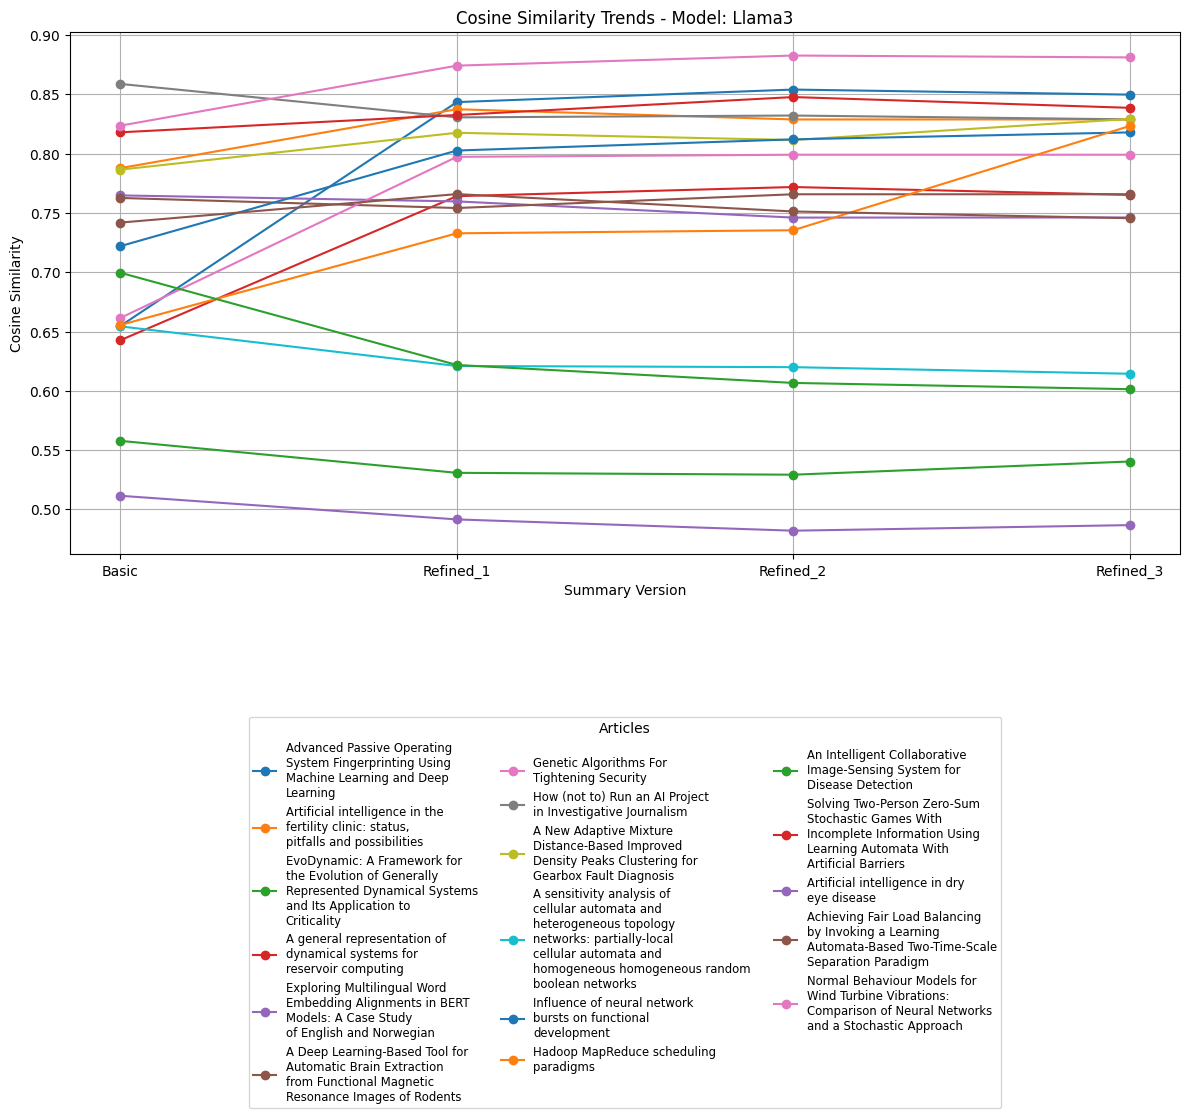


Example Summary Refinement for Model: Llama3
Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

Original Abstract:

: In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use 

In [45]:
# evaluate Llama3 with grid search, similarity trends, and example summary
run_evaluation_for_model(
    model_name="Llama3",
    example_article_id=1,
    max_iterations=3,
)

In [ ]:
# evaluate Falcon3 with grid search, similarity trends, and example summary
run_evaluation_for_model(
    model_name="Falcon3",
    example_article_id=1,
    max_iterations=3,
)

'run_evaluation_for_model(\n    model_name="Falcon3",\n    example_article_id=1,\n    max_iterations=3,\n)'

In [ ]:
# evaluate Granite with grid search, similarity trends, and example summary
run_evaluation_for_model(
    model_name="Granite",
    example_article_id=1,
    max_iterations=3,
)

### <a id="llm-significance"></a> 3.4) Significance Testing

To assess whether iterative refinement leads to statistically significant improvements, a Wilcoxon signed-rank test is performed for each model. The test compares cosine similarity scores before and after refinement. Results are reported along with average and median changes in similarity. Visualizations include before/after similarity scores and per-article gains to illustrate which articles benefited most—and where regressions occurred.

[⬆️ Back to Top](#top)


In [46]:
# Wilcoxon Signed-Rank Test for each model
for model_name, cosine_similarity_per_article in model_results.items():
    before_scores = []
    after_scores = []

    # loop through each article's cosine similarity data
    for data in cosine_similarity_per_article.values():

        # get before and after scores
        before = data["similarity_scores"][0]
        after = data["similarity_scores"][-1]
        before_scores.append(before)
        after_scores.append(after)

    # perform test
    if len(before_scores) >= 2:  # ensure there are at least two pairs for the test
        stat, p_value = wilcoxon(before_scores, after_scores, alternative='less')

        # print results for the model
        print("\n" + "=" * 50)
        print(f"Wilcoxon Signed-Rank Test (Refinement Improvement) - Model: {model_name}")
        print("=" * 50)
        print(f"Test Statistic: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("Statistically significant improvement after refinement (p < 0.05)")
        else:
            print("No statistically significant improvement (p ≥ 0.05)")
        print("=" * 50 + "\n")
    else:
        print(f"Not enough paired data for the Wilcoxon test in model {model_name}.")



Wilcoxon Signed-Rank Test (Refinement Improvement) - Model: Llama3
Test Statistic: 41.0000
P-value: 0.0492
✅ Statistically significant improvement after refinement (p < 0.05)



In [47]:
# print mean and median similarity scores
print(f"Average similarity before refinement: {np.mean(before_scores):.4f}")
print(f"Average similarity after refinement:  {np.mean(after_scores):.4f}")
print(f"Median similarity before refinement:  {np.median(before_scores):.4f}")
print(f"Median similarity after refinement:   {np.median(after_scores):.4f}")

Average similarity before refinement: 0.7120
Average similarity after refinement:  0.7508
Median similarity before refinement:  0.7220
Median similarity after refinement:   0.7991


In [48]:
# print mean and median difference in similarity scores
differences = np.array(after_scores) - np.array(before_scores)
print(f"Differences in similarity scores: {differences}")
print(f"Mean difference: {np.mean(differences):.4f}")
print(f"Median difference: {np.median(differences):.4f}")

Differences in similarity scores: [ 0.19506353  0.04103744 -0.0174185   0.12259007 -0.01862168  0.00310141
  0.13765049 -0.02988309  0.04275924 -0.03994447  0.09591693  0.16777682
 -0.09818554  0.02065158 -0.02473205  0.00369537  0.05757254]
Mean difference: 0.0388
Median difference: 0.0207


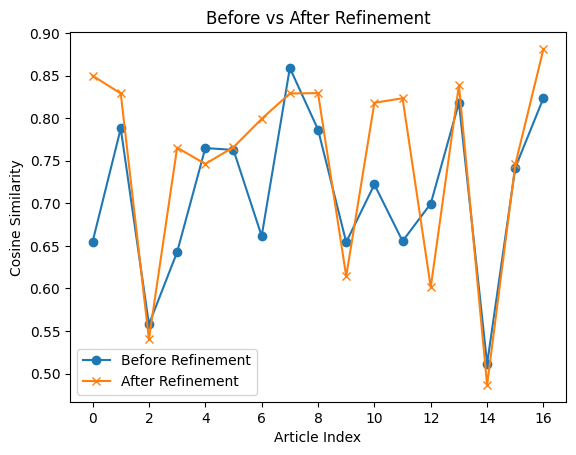

In [49]:
# plot similarity scores before and after refinement
plt.plot(before_scores, label="Before Refinement", marker='o')
plt.plot(after_scores, label="After Refinement", marker='x')
plt.xlabel("Article Index")
plt.ylabel("Cosine Similarity")
plt.title("Before vs After Refinement")
plt.legend()
plt.show()

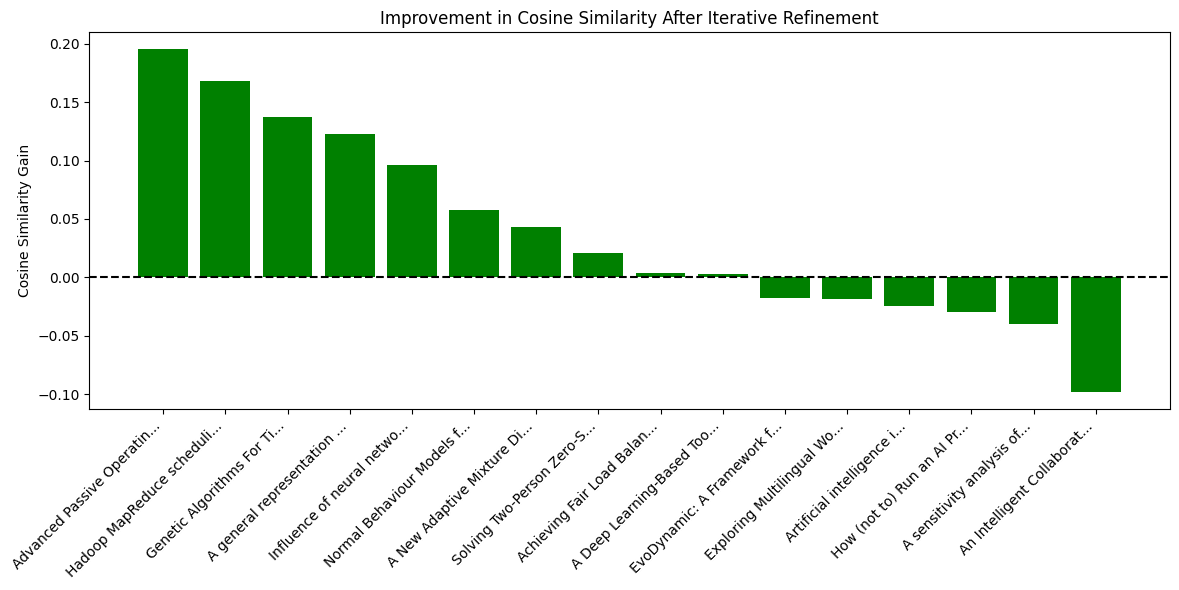

In [50]:
# compute cosine similarity difference per article
diff_scores = {}
for title, data in cosine_similarity_per_article.items():
    if len(data["similarity_scores"]) >= 2:
        initial = data["similarity_scores"][0]
        final = data["similarity_scores"][-1]
        diff = final - initial
        short_title = title[:25] + "..." if len(title) > 25 else title
        diff_scores[short_title] = diff

# sort by improvement
sorted_diff = dict(sorted(diff_scores.items(), key=lambda item: item[1], reverse=True))

# plot differential improvement
plt.figure(figsize=(12, 6))
plt.bar(sorted_diff.keys(), sorted_diff.values(), color='green')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cosine Similarity Gain")
plt.title("Improvement in Cosine Similarity After Iterative Refinement")
plt.tight_layout()
plt.show()

In [51]:
# print articles where summary refinement decreased similarity
for title, diff in diff_scores.items():
    if diff < 0:
        print(f"Regression: {title} -> {diff:.4f}")

Regression: Artificial intelligence i... -> -0.0247
Regression: EvoDynamic: A Framework f... -> -0.0174
Regression: Exploring Multilingual Wo... -> -0.0186
Regression: How (not to) Run an AI Pr... -> -0.0299
Regression: A sensitivity analysis of... -> -0.0399
Regression: An Intelligent Collaborat... -> -0.0982


### <a id="shuffle"></a> 3.5) Shuffle Abstracts

This section introduces a control experiment to evaluate the reliability of cosine similarity as a metric for summary faithfulness. It involves shuffling the abstracts in the dataset and comparing the LLM-generated summary of a given article with both its original abstract and a randomly assigned (shuffled) one. Cosine similarity is calculated in both cases to determine whether the similarity score meaningfully distinguishes between truly related content and unrelated content. A higher similarity with the original abstract and a lower similarity with the shuffled abstract would indicate that the evaluation metric can effectively capture semantic alignment.

[⬆️ Back to Top](#top)

In [ ]:
# set up a text generation pipeline with custom parameters
llm_pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    return_full_text=False
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

# create a QA chain using retriever and LLM
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
)

In [ ]:
def shuffle_abstracts(df):
    """
    Randomly shuffles the abstracts while keeping titles unchanged.

    Args:
        df: DataFrame containing an 'abstract' column.

    Returns:
        list: Shuffled list of abstracts.
    """

    # extract abstracts as a list
    shuffled_abstracts = df["abstract"].tolist()

    # shuffle abstracts in place
    random.shuffle(shuffled_abstracts)
    return shuffled_abstracts

In [ ]:
def evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain, model, sim_model):
    """
    Evaluates how faithful a generated summary is by comparing its cosine similarity
    to the correct abstract vs. a randomly shuffled one (control test).

    Args:
        article_id: Index of the article in the DataFrame.
        df: DataFrame with 'title' and 'abstract' columns.
        retriever: Document retriever for fetching relevant context.
        qa_chain: QA chain for generating summaries.
        model: Not used here, but included for compatibility.
        sim_model: Sentence embedding model for computing cosine similarity.

    Returns:
        dict: Contains original/shuffled abstracts, summary, and similarity scores.
    """
    # extract article title and abstract
    article = df.iloc[article_id]
    original_abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents
    retrieved_docs = retriever.invoke(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "shuffled_abstract": None,
            "generated_summary": "No relevant documents found.",
            "Original Cosine Similarity": None,
            "Shuffled Cosine Similarity": None
        }

    # generate a summary using the QA chain
    query = f"Summarize the research article titled: {title}"
    response = qa_chain.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    # select shuffled abstract (same index, random order)
    shuffled_abstracts = shuffle_abstracts(df)
    shuffled_abstract = shuffled_abstracts[article_id]

    # compute cosine similarity between summary and original abstract
    original_embeddings = sim_model.encode([original_abstract, generated_summary])
    original_similarity = cosine_similarity([original_embeddings[0]], [original_embeddings[1]])[0][0]

    # compute similarity between summary and shuffled abstract
    shuffled_embeddings = sim_model.encode([shuffled_abstract, generated_summary])
    shuffled_similarity = cosine_similarity([shuffled_embeddings[0]], [shuffled_embeddings[1]])[0][0]

    return {
        "title": title,
        "original_abstract": original_abstract,
        "shuffled_abstract": shuffled_abstract,
        "generated_summary": generated_summary,
        "Original Cosine Similarity": original_similarity,
        "Shuffled Cosine Similarity": shuffled_similarity
    }

In [ ]:
# evaluate cosine similarity drop using shuffled abstracts for selected articles
article_ids = [4, 7, 11]
results = []

for article_id in article_ids:
    result = evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain, sim_model, sim_model)
    results.append(result)

# print comparison of similarity scores
for result in results:
    print(f"Title: {result['title']}")
    print(f"Original Cosine Similarity: {result['Original Cosine Similarity']:.4f}")
    print(f"Shuffled Cosine Similarity: {result['Shuffled Cosine Similarity']:.4f}")
    print("=" * 50)

Title: Exploring Multilingual Word Embedding Alignments in BERT Models: A Case Study of English and Norwegian
Original Cosine Similarity: 0.6661
Shuffled Cosine Similarity: 0.0678
Title: How (not to) Run an AI Project in Investigative Journalism
Original Cosine Similarity: 0.8048
Shuffled Cosine Similarity: 0.0610
Title: Hadoop MapReduce scheduling paradigms
Original Cosine Similarity: 0.8978
Shuffled Cosine Similarity: 0.1207


In [ ]:
# extract data for plotting
titles = [r["title"] for r in results]
original_similarities = [r["Original Cosine Similarity"] for r in results]
shuffled_similarities = [r["Shuffled Cosine Similarity"] for r in results]

def wrap_title(title, max_words=6):
    """
    Helper to wrap long titles for better readability in the plot.
    """
    words = title.split()
    return "\n".join([" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)])

wrapped_titles = [wrap_title(title) for title in titles]

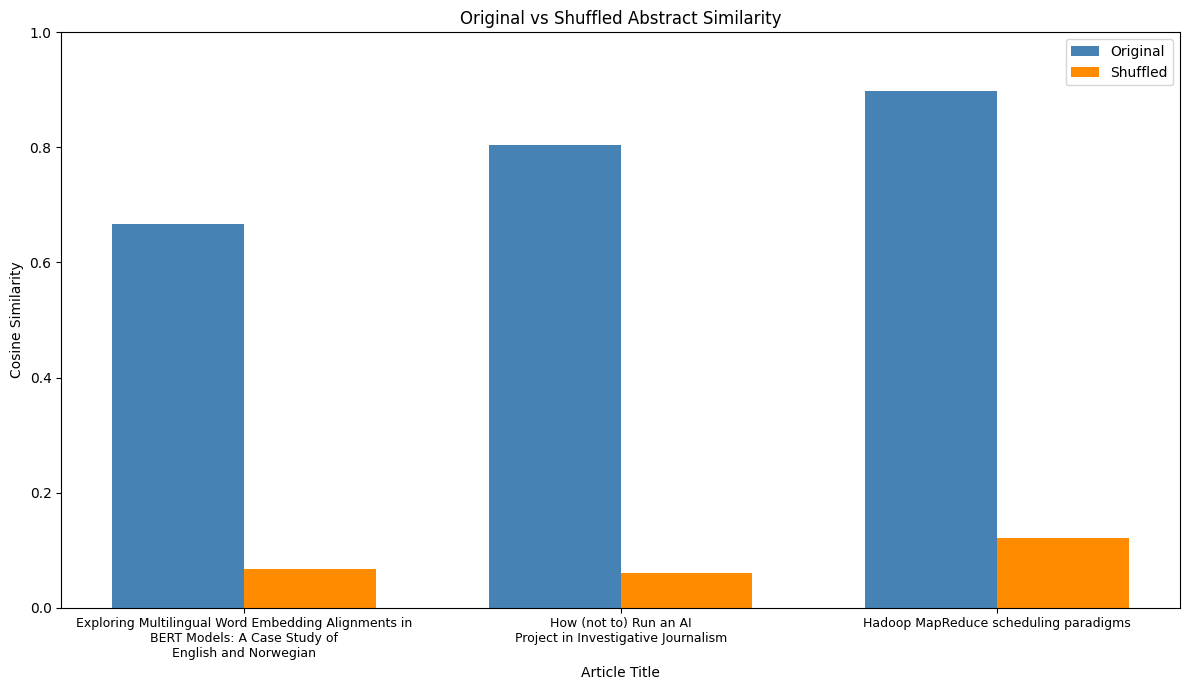

In [ ]:
x = np.arange(len(titles))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, original_similarities, width, label='Original', color='steelblue')
plt.bar(x + width/2, shuffled_similarities, width, label='Shuffled', color='darkorange')

plt.xlabel('Article Title')
plt.ylabel('Cosine Similarity')
plt.title('Original vs Shuffled Abstract Similarity')
plt.xticks(ticks=x, labels=wrapped_titles, rotation=0, ha='center', fontsize=9)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## <a id="hallucination"></a> 4) Hallucination Detection

### <a id="sentence-processing"></a> 4.1) Sentence Processing

This section prepares the generated summaries for hallucination analysis by breaking them down into individual sentences. A simple sentence splitting function is defined using regular expressions to segment text at punctuation marks commonly indicating sentence boundaries (e.g., periods, exclamation points, and question marks). Each resulting sentence is stripped of leading and trailing whitespace. This preprocessing step enables finer-grained evaluation, where each sentence can later be assessed for its factual alignment with the source documents.

[⬆️ Back to Top](#top)

In [68]:
def sentence_splitting(text):
    """
    Splits a text string into individual sentences using punctuation-based boundaries.

    Args:
        text: The input text to split.

    Returns:
        list: List of cleaned sentences with leading/trailing whitespace removed.
    """
    return [s.strip() for s in re.split(r'(?<=[.!?]) +', text) if s.strip()]

### <a id="similarities"></a> 4.2) Compute Similarities and Thresholds

In this section, the semantic similarity between sentences from generated summaries and reference texts is calculated using sentence embeddings. The `sentence_cosine_similarity` function encodes both sets of sentences using a shared embedding model and computes the pairwise cosine similarity matrix. This provides a fine-grained measure of how closely each summary sentence aligns with the article content.

To identify hallucinated content, the `compute_similarity_thresholds` function is used to derive similarity thresholds based on the distribution of scores. Instead of relying on a fixed percentile, the function applies Kernel Density Estimation (KDE) and selects the first local minimum in the similarity distribution as the threshold. This valley-based thresholding helps separate well-supported sentences from those that may be weakly grounded or hallucinated, guiding downstream detection.

[⬆️ Back to Top](#top)

In [ ]:
def sentence_cosine_similarity(sentences1, sentences2, model):
    """
    Computes the pairwise cosine similarity between two lists of sentences using embeddings.

    Args:
        sentences1: First list of sentences.
        sentences2: Second list of sentences.
        model: Model used to encode sentences into embeddings.

    Returns:
        np.ndarray: A 2D array of cosine similarity scores between sentence pairs.
    """
    embeddings1 = model.encode(sentences1, convert_to_tensor=True).cpu()
    embeddings2 = model.encode(sentences2, convert_to_tensor=True).cpu()
    return cosine_similarity(embeddings1, embeddings2)

In [ ]:
def find_kde_valley_threshold(similarities):
    """
    Estimate a threshold from similarity scores using the first local minimum
    of the kernel density estimate (KDE). Falls back to the 25th percentile
    if no local minimum is found.

    Parameters:
        similarities: List or array of similarity scores.

    Returns:
        float: Estimated similarity threshold.
    """
    # handle edge cases: return min if one value, 0.0 if empty
    if len(similarities) < 2:
        return np.min(similarities) if len(similarities) == 1 else 0.0

    # fit KDE over the similarity values
    kde = gaussian_kde(similarities)

    # generate smooth range of values across the similarity span
    x = np.linspace(min(similarities), max(similarities), 1000)

    # evaluate KDE at these points
    y = kde(x)

    # find indices of local minima in the KDE curve
    minima_indices = argrelextrema(y, np.less)[0]

    # if no local minima are found, fall back to a fixed percentile
    if len(minima_indices) == 0:
        return np.percentile(similarities, 25)

    return x[minima_indices[0]]

In [ ]:
def compute_similarity_thresholds(similarities_dict):
    """
    Compute KDE-based similarity thresholds for multiple types of similarity scores
    (mean, max, min). Uses the first valley in the KDE curve to identify
    a separation point between likely factual and hallucinatory content.

    Args:
        similarities_dict: A dictionary where each key is a similarity type and the value is a list or array of similarity scores.

    Returns:
        dict: A dictionary with the same keys as the input, mapping each to its corresponding computed threshold.
    """
    thresholds = {}

    # iterate over each type of similarity score
    for name, sims in similarities_dict.items():
        sims_arr = np.array(sims)

        # if no scores available, set threshold to 0
        if len(sims_arr) == 0:
            thresholds[name] = 0.0

        # use KDE to find a threshold based on valley in distribution
        else:
            threshold = find_kde_valley_threshold(sims_arr)
            thresholds[name] = threshold

            # log the computed threshold
            print(f"KDE-based threshold for {name}: {threshold:.4f}")

    return thresholds

### <a id="identify-hallucinations"></a> 4.3) Identify Hallucinations in Generated Summaries

This section implements a systematic approach to detect hallucinations in generated summaries by analyzing sentence-level semantic similarity. Each sentence in the summary is compared against the source document sentences using cosine similarity. A sentence is flagged as hallucinated if its similarity falls below one or more thresholds (mean, max, min). Thresholds are computed using the 25th percentile of observed scores. The code also supports visualizing similarity distributions and comparing summary vs. abstract alignment.

[⬆️ Back to Top](#top)

In [ ]:
def identify_hallucinations(similarities, summary_sentences, article_sentences, thresholds, level):
    """
    Flags potentially hallucinated summary sentences based on similarity thresholds.
    For each summary sentence, checks if mean, max, or min similarity to article
    sentences falls below thresholds. Also flags those failing both mean and max.

    Args:
        similarities: 2D array of similarity scores (summary × article).
        summary_sentences: List of summary sentences.
        article_sentences: List of article sentences.
        thresholds: Dict with "mean", "max", and "min" thresholds.
        level: Summary refinement level.

    Returns:
        tuple: Lists of hallucinations by mean, max, min, and both thresholds.
    """
    mean_h, max_h, min_h, both_h = [], [], [], []
    for idx, sim_scores in enumerate(similarities):

        # compute summary-to-article similarity statistics
        mean_sim = np.mean(sim_scores)
        max_sim = np.max(sim_scores)
        min_sim = np.min(sim_scores)

        # retrieve the most similar article sentence for context
        most_similar_sentence = article_sentences[np.argmax(sim_scores)]
        sentence = summary_sentences[idx]

        # check if similarity falls below thresholds and flag accordingly
        if mean_sim < thresholds["mean"]:
            mean_h.append({"level": level, "summary_sentence": sentence, "similarity_score": mean_sim, "article_sentence": most_similar_sentence})
        if max_sim < thresholds["max"]:
            max_h.append({"level": level, "summary_sentence": sentence, "similarity_score": max_sim, "article_sentence": most_similar_sentence})
        if min_sim < thresholds["min"]:
            min_h.append({"level": level, "summary_sentence": sentence, "similarity_score": min_sim, "article_sentence": most_similar_sentence})
        if mean_sim < thresholds["mean"] and max_sim < thresholds["max"]:
            both_h.append({"level": level, "summary_sentence": sentence, "mean_similarity_score": mean_sim, "max_similarity_score": max_sim, "article_sentence": most_similar_sentence})

    return mean_h, max_h, min_h, both_h

In [ ]:
def detect_hallucinations(article_id, df, retriever, qa_chain, sim_model):
    """
    Detect hallucinated summary sentences by comparing them to article content
    using cosine similarity and KDE-based thresholds.

    Args:
        article_id: Index of the article in the DataFrame.
        df: DataFrame containing article data.
        retriever: Document retriever for context.
        qa_chain: Summarization or QA pipeline.
        sim_model: Sentence embedding model.

    Returns:
        tuple: Article title, four hallucination lists (mean, max, min, both),
               and a dict of similarity scores.
    """
    # generate summaries and retrieve relevant documents
    summary_data = abstract_summary_comparison(article_id, df, retriever, qa_chain, sim_model)
    article = df.iloc[article_id]
    article_title = article["title"]
    article_text = article["cleaned_content"]
    article_abstract = article["abstract"]

    if not summary_data["retrieved_docs"]:
        return article_title, [], [], [], [], {"mean": [], "max": [], "min": []}

    # split article into sentences and compute embeddings
    article_sentences = sentence_splitting(article_text)
    article_embeddings = sim_model.encode(article_sentences, convert_to_tensor=True).cpu()

    all_sims = {"mean": [], "max": [], "min": []}
    level_sims = {}
    all_flattened_summary_similarities = []

    # compute similarities for each summary level
    for level, summary in summary_data["generated_summaries"].items():
        summary_sentences = sentence_splitting(summary)
        summary_embeddings = sim_model.encode(summary_sentences, convert_to_tensor=True).cpu()
        sims = cosine_similarity(summary_embeddings, article_embeddings)

        level_sims[level] = (summary_sentences, sims)
        all_sims["mean"].extend(np.mean(sims, axis=1))
        all_sims["max"].extend(np.max(sims, axis=1))
        all_sims["min"].extend(np.min(sims, axis=1))
        all_flattened_summary_similarities.append(sims.flatten())

    # compute thresholds using KDE-based valley detection
    thresholds = compute_similarity_thresholds(all_sims)

    # plot similarity distribution for generated summaries
    if all_flattened_summary_similarities:
        all_flattened_summary_similarities = np.concatenate(all_flattened_summary_similarities)
        plt.figure(figsize=(8,5))
        sns.histplot(all_flattened_summary_similarities, bins=30, kde=True, color="blue", edgecolor="black", alpha=0.7)
        plt.axvline(thresholds["mean"], color='red', linestyle='dashed', linewidth=2, label=f'Mean Threshold: {thresholds["mean"]:.2f}')
        plt.axvline(thresholds["max"], color='orange', linestyle='dashed', linewidth=2, label=f'Max Threshold: {thresholds["max"]:.2f}')
        plt.axvline(thresholds["min"], color='green', linestyle='dashed', linewidth=2, label=f'Min Threshold: {thresholds["min"]:.2f}')
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Frequency")
        plt.title(f"Generated Summary vs Full Article (Article ID {article_id})")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    # compare original abstract to full article for reference
    abstract_sentences = sentence_splitting(article_abstract)
    abstract_embeddings = sim_model.encode(abstract_sentences, convert_to_tensor=True).cpu()
    sims_abstract = cosine_similarity(abstract_embeddings, article_embeddings)

    # plot similarity distribution for abstract
    all_flattened_abstract_similarities = sims_abstract.flatten()
    plt.figure(figsize=(8,5))
    sns.histplot(all_flattened_abstract_similarities, bins=30, kde=True, color="green", edgecolor="black", alpha=0.7)
    plt.axvline(thresholds["mean"], color='red', linestyle='dashed', linewidth=2, label=f'Mean Threshold: {thresholds["mean"]:.2f}')
    plt.axvline(thresholds["max"], color='orange', linestyle='dashed', linewidth=2, label=f'Max Threshold: {thresholds["max"]:.2f}')
    plt.axvline(thresholds["min"], color='green', linestyle='dashed', linewidth=2, label=f'Min Threshold: {thresholds["min"]:.2f}')
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title(f"Original Abstract vs Full Article (Article ID {article_id})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # run hallucination detection per summary level
    hallucinations_mean, hallucinations_max, hallucinations_min, hallucinations_both = [], [], [], []
    for level, (summary_sentences, sims) in level_sims.items():
        mean_h, max_h, min_h, both_h = identify_hallucinations(sims, summary_sentences, article_sentences, thresholds, level)
        hallucinations_mean.extend(mean_h)
        hallucinations_max.extend(max_h)
        hallucinations_min.extend(min_h)
        hallucinations_both.extend(both_h)

    sim_scores_dict = {
        "mean": [h["similarity_score"] for h in hallucinations_mean],
        "max": [h["similarity_score"] for h in hallucinations_max],
        "min": [h["similarity_score"] for h in hallucinations_min]
    }

    return article_title, hallucinations_mean, hallucinations_max, hallucinations_min, hallucinations_both, sim_scores_dict, thresholds


In [ ]:
def print_hallucinations(title, data, sim_key="similarity_score"):
    """
    Print detected hallucinated summary sentences with similarity scores
    and their most similar article sentence.

    Args:
        title: Label for the type of hallucination.
        data: List of hallucination entries to display.
        sim_key: Key used to extract the similarity score.
    """
    if data:
        print(f"\nDetected Hallucinations ({title}):")

        # print details for each hallucinated sentence
        for h in data:
            print(f"Level: {h['level']}")
            print(f"Summary Sentence: {h['summary_sentence']}")
            print(f"Similarity Score: {h.get(sim_key, 0):.4f}")
            print(f"Most Similar Article Sentence: {h['article_sentence']}\n" + "-" * 50)
    else:
        print(f"\nNo hallucinations detected based on {title.lower()}.")

### <a id="multi-article-detection"></a> 4.4) Multi-Article Detection and Visualization

Here, hallucination detection is applied across multiple research articles. For each article, hallucinated sentences are reported, grouped by similarity strategy (mean, max, min, both). Summary-level and article-level statistics are collected, and visualizations are generated to highlight differences between summaries and source texts. This step gives insight into hallucination frequency across the dataset and helps evaluate the effectiveness of detection thresholds.

[⬆️ Back to Top](#top)

In [ ]:
def detect_hallucinations_multiple(article_ids, df, retriever, qa_chain, sim_model):
    """
    Detect hallucinations across multiple articles and return summary stats.

    Args:
        article_ids: List of article indices.
        df: DataFrame with article content.
        retriever: Context retriever.
        qa_chain: Summary or QA pipeline.
        sim_model: Embedding model.

    Returns:
        tuple: stats_df, results, and combined similarity scores.
    """
    results = []
    stats = []
    all_sims_list = []
    for article_id in article_ids:
        try:
            # detect hallucinations for the current article
            article_title, halluc_mean, halluc_max, halluc_min, halluc_both, sim_scores_dict, thresholds = detect_hallucinations(
            article_id, df, retriever, qa_chain, sim_model
            )

            print(f"\nArticle Title: {article_title}\n" + "=" * 50)
            print_hallucinations("Mean Similarity", halluc_mean)
            print_hallucinations("Max Similarity", halluc_max)
            print_hallucinations("Min Similarity", halluc_min)

            # print hallucinations failing both mean and max thresholds
            if halluc_both:
                print("\nDetected Hallucinations: Both Mean and Max Similarity:")
                for h in halluc_both:
                    print(f"Level: {h['level']}")
                    print(f"Mean Similarity Score: {h['mean_similarity_score']:.4f}")
                    print(f"Max Similarity Score: {h['max_similarity_score']:.4f}")
                    print(f"Summary Sentence: {h['summary_sentence']}")
                    print(f"Most Similar Article Sentence: {h['article_sentence']}\n" + "-" * 50)
            else:
                print("\nNo hallucinations detected for both thresholds.")

            # plot hallucinated similarity distributions using the original thresholds
            plot_per_article_similarity_distributions(sim_scores_dict, thresholds, article_id)

            # store full hallucination data
            results.append({
                "article_id": article_id,
                "article_title": article_title,
                "hallucinations_mean": halluc_mean,
                "hallucinations_max": halluc_max,
                "hallucinations_min": halluc_min,
                "hallucinations_both": halluc_both,
            })

            # store summary statistics
            stats.append({
                "article_id": article_id,
                "article_title": article_title,
                "mean_count": len(halluc_mean),
                "max_count": len(halluc_max),
                "min_count": len(halluc_min),
                "both_count": len(halluc_both),
                "mean_threshold": thresholds["mean"],
                "max_threshold": thresholds["max"],
                "min_threshold": thresholds["min"]
            })
            all_sims_list.append(sim_scores_dict)

        except Exception as e:
            print(f"\nError processing article ID {article_id}: {e}")
            continue

    # combine all per-article similarity scores
    stats_df = pd.DataFrame(stats)
    combined_similarities = {
        "mean": np.concatenate([sims["mean"] for sims in all_sims_list if sims["mean"]]) if any(sims["mean"] for sims in all_sims_list) else np.array([]),
        "max": np.concatenate([sims["max"] for sims in all_sims_list if sims["max"]]) if any(sims["max"] for sims in all_sims_list) else np.array([]),
        "min": np.concatenate([sims["min"] for sims in all_sims_list if sims["min"]]) if any(sims["min"] for sims in all_sims_list) else np.array([])
    }

    # print hallucination summary table
    print("\n--- Summary of Hallucination Statistics ---")
    print(stats_df[["article_id", "article_title", "mean_count", "max_count", "min_count", "both_count"]])
    return stats_df, results, combined_similarities

In [ ]:
def plot_per_article_similarity_distributions(similarities_dict, thresholds, article_id):
    """
    Plot similarity distributions with KDE and thresholds for a given article.

    Args:
        similarities_dict: Dict of similarity scores (mean, max, min).
        thresholds: Dict of corresponding KDE-based thresholds.
        article_id: ID of the article being visualized.
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, (label, sim_array) in zip(axes, similarities_dict.items()):
        if len(sim_array) == 0:
            continue

        # plot histogram and KDE for current similarity type
        sns.histplot(sim_array, bins=30, kde=True, color="blue", ax=ax, alpha=0.6, edgecolor="black")

        # draw threshold line on the distribution
        ax.axvline(thresholds[label], color='red', linestyle='dashed', linewidth=2,
                   label=f"{label.capitalize()} Threshold: {thresholds[label]:.4f}")

        ax.set_xlabel(f"Cosine Similarity ({label.capitalize()})")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Distribution of {label.capitalize()} Similarities (Article ID {article_id})")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

KDE-based threshold for mean: 0.1411
KDE-based threshold for max: 0.7415
KDE-based threshold for min: -0.0769


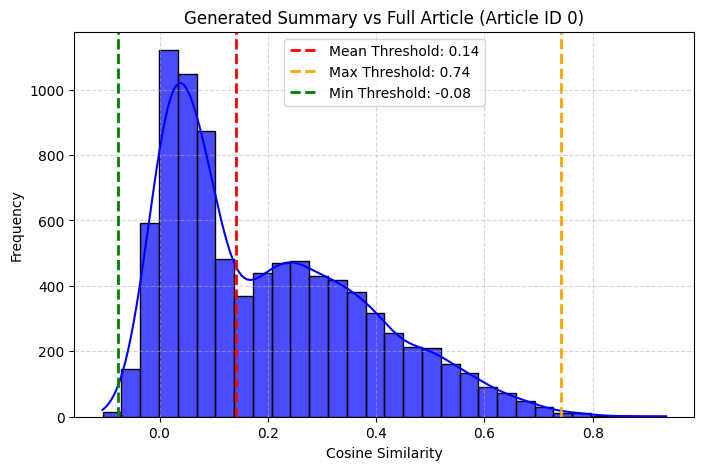

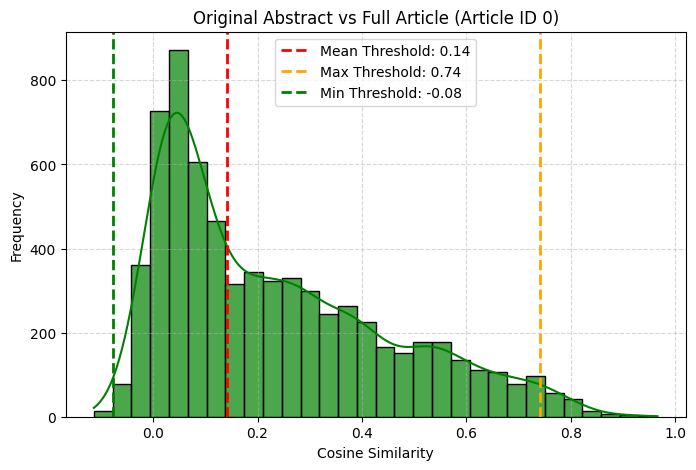


Article Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

Detected Hallucinations (Mean Similarity):
Level: specialized
Summary Sentence: The fingerprint is then represented as a vector, which is used as input to the deep neural network.

The study demonstrates the effectiveness of the proposed approach, which outperforms existing methods in terms of accuracy and robustness.
Similarity Score: 0.1125
Most Similar Article Sentence: Engelstad ¶ ∗§¶University of Oslo, Department of Technology Systems, Kjeller, Norway ∗†‡¶Oslo Metropolitan University, Department of Computer Science, Oslo, Norway Email: ∗destahh@iﬁ.uio.no, †martin.loeland@gmail.com, {‡anis.yazidi, ¶paal.engelstad}@oslomet.no, §oivind.kure@its.uio.no Abstract Keywords—Operating System, Fingerprinting, Machine Learning, Deep Learning, Passive Measurements I.
--------------------------------------------------

Detected Hallucinations (Max Similarity):
Level: basic
Summary Sentenc

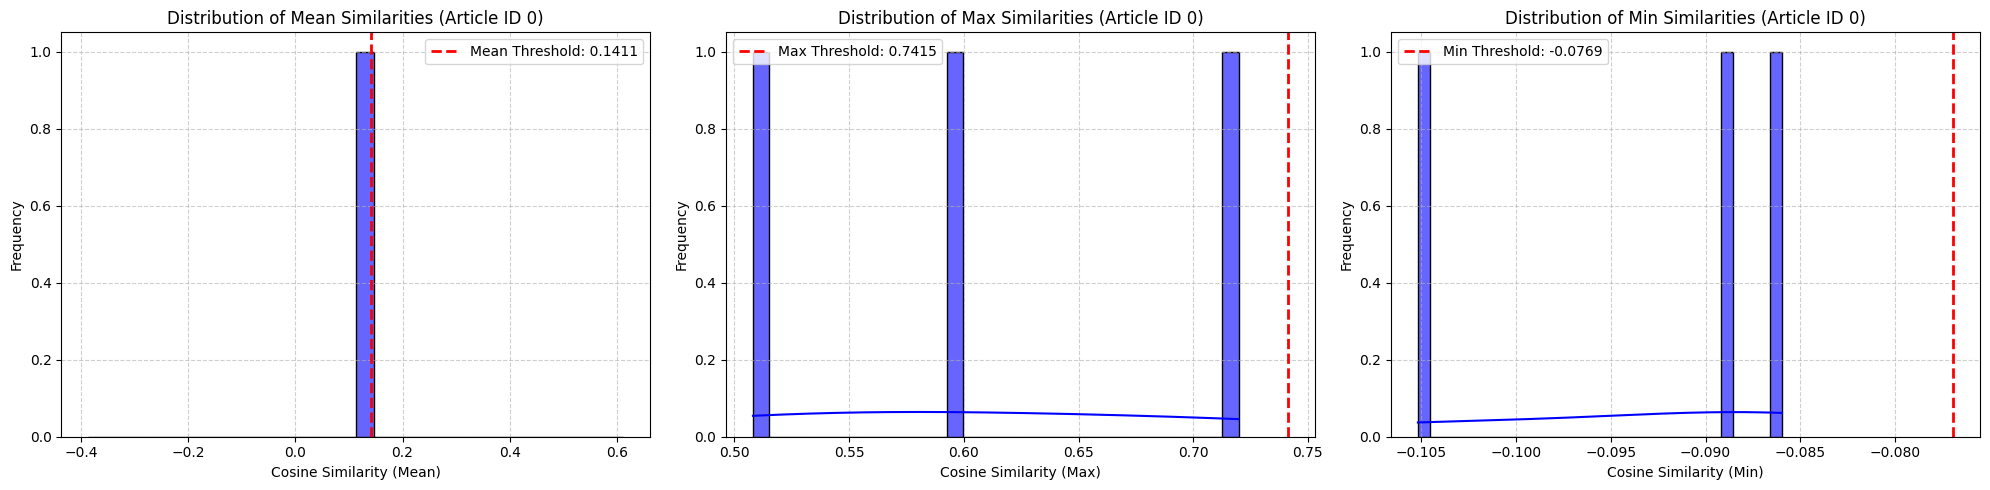


--- Summary of Hallucination Statistics ---
   article_id                                      article_title  mean_count  \
0           0  Advanced Passive Operating System Fingerprinti...           1   

   max_count  min_count  both_count  
0          3          3           1  


In [ ]:
article_ids = [0]

# run detection
stats_df, results, all_sims = detect_hallucinations_multiple(
    article_ids, df, retriever, qa_chain, sim_model
)

### <a id="trends"></a> 4.5) Overall Hallucination Trends

This section summarizes hallucination detection results across articles and visualizes the number of flagged sentences using different threshold criteria. A bar chart is used to show hallucination counts per article, helping to identify which summaries are most prone to factual drift. The visualization also aids in understanding the sensitivity of various similarity metrics in detecting hallucinated content.

[⬆️ Back to Top](#top)

In [ ]:
print("\n--- Summary of Hallucination Statistics ---")
stats_df


--- Summary of Hallucination Statistics ---


,article_id,article_title,mean_count,max_count,min_count,both_count,mean_threshold,max_threshold,min_threshold
0,0,Advanced Passive Operating System Fingerprinti...,1,3,3,1,0.141134,0.741459,-0.076941


## <a id="case-study"></a> 5) Hallucination Case Study

In [56]:
!git clone https://github.com/RUCAIBox/HaluEval.git

Cloning into 'HaluEval'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 171 (delta 5), reused 2 (delta 2), pack-reused 141 (from 2)
Receiving objects: 100% (171/171), 39.21 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [57]:
!ls HaluEval/data

dialogue_data.json  general_data.json  qa_data.json  summarization_data.json


### <a id="load-process"></a> 5.1) Load and Process Dataset

The HaluEval dataset is loaded from a JSONL file, where each entry contains a document, a hallucinated summary, and a ground truth summary. During loading, a random selection is made between the hallucinated and factual summary to simulate realistic input conditions. The selected summary, along with associated metadata (e.g., article ID, title, ground truth), is structured into a DataFrame for downstream analysis. Additionally, the raw dataset is returned to allow inspection of the original data format.

[⬆️ Back to Top](#top)

In [69]:
def load_halu_eval(filepath):
    """
    Load the HaluEval dataset and randomly select either
    a hallucinated or factual summary per entry.

    Args:
        filepath: Path to the HaluEval JSONL file.

    Returns:
        tuple: (data frae with summaries and labels, raw JSON data list).
    """
    halu_data = []

    # read each line in the file as a separate JSON object
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            halu_data.append(json.loads(line.strip()))

    data = []

    # randomly choose either factual or hallucinated summary for each article
    for i, item in enumerate(halu_data):
        if random.random() < 0.5:
            chosen_summary = item["hallucinated_summary"]
            is_hallucinated_summary = 1
        else:
            chosen_summary = item["right_summary"]
            is_hallucinated_summary = 0

        data.append({
            "article_id": i,
            "title": f"HaluEval Sample {i}",
            "cleaned_content": item["document"],
            "summary": chosen_summary,
            "ground_truth_summary": item["right_summary"],
            "is_hallucinated_summary": is_hallucinated_summary
        })

    # create structured data frame for further processing
    halu_df = pd.DataFrame(data)
    return halu_df, halu_data

In [70]:
# load HaluEval dataset and print first raw JSON example
halu_df, halu_data = load_halu_eval("HaluEval/data/summarization_data.json")
print(json.dumps(halu_data[0], indent=2))

{
  "document": "Marseille, France (CNN)The French prosecutor leading an investigation into the crash of Germanwings Flight 9525 insisted Wednesday that he was not aware of any video footage from on board the plane. Marseille prosecutor Brice Robin told CNN that \"so far no videos were used in the crash investigation.\" He added, \"A person who has such a video needs to immediately give it to the investigators.\" Robin's comments follow claims by two magazines, German daily Bild and French Paris Match, of a cell phone video showing the harrowing final seconds from on board Germanwings Flight 9525 as it crashed into the French Alps. All 150 on board were killed. Paris Match and Bild reported that the video was recovered from a phone at the wreckage site. The two publications described the supposed video, but did not post it on their websites. The publications said that they watched the video, which was found by a source close to the investigation. \"One can hear cries of 'My God' in sev

### <a id="max-cosine"></a> 5.2) Max Cosine Similarity for Sentence-Level Detection

This section implements a method to detect hallucinated sentences in summaries by evaluating their maximum semantic similarity to the original article sentences. Each summary sentence is compared to all article sentences using cosine similarity of sentence embeddings. If the highest similarity falls below a specified threshold and the sentence is not lexically similar to any article sentence (based on character-level sequence matching), it is flagged as hallucinated. This dual check—semantic and lexical—helps filter out unsupported statements while avoiding false positives due to paraphrasing.

[⬆️ Back to Top](#top)

In [71]:
def is_lexically_similar(a, b, threshold=0.6):
    """
    Returns True if two strings are lexically similar based on a sequence matching ratio.

    Args:
        a: First string to compare.
        b: Second string to compare.
        threshold: Similarity threshold between 0 and 1.

    Returns:
        bool: True if similarity ratio >= threshold, otherwise False.
    """
    return difflib.SequenceMatcher(None, a, b).ratio() >= threshold

In [72]:
def detect_max_similarity(article_id, df, sim_model, summary_type, threshold=0.6):
    """
    Detects hallucinated summary sentences using cosine and lexical similarity.

    Args:
        article_id: Row index in the DataFrame.
        df: Dataset with articles and summaries.
        sim_model: Embedding model.
        summary_type: Column name of the summary.
        threshold: Similarity cutoff for flagging hallucinations.

    Returns:
        tuple: (list of flagged sentences, list of hallucinated indices)
    """

    # extract content and split into sentences
    row = df.iloc[article_id]
    article_sentences = sentence_splitting(row["cleaned_content"])
    summary_sentences = sentence_splitting(row[summary_type])

    # handle empty cases
    if not article_sentences or not summary_sentences:
        return [], []

    # compute embeddings and similarity matrix
    article_embeds = sim_model.encode(article_sentences, convert_to_tensor=True).cpu()
    summary_embeds = sim_model.encode(summary_sentences, convert_to_tensor=True).cpu()
    similarity_matrix = cosine_similarity(summary_embeds, article_embeds)

    results, hallucinated_indices = [], []

    # analyze similarity scores for each summary sentence
    for idx, row_sim in enumerate(similarity_matrix):
        max_sim = np.max(row_sim)
        most_similar = article_sentences[np.argmax(row_sim)]

        # flag sentence as hallucinated if similarity is low and it's not lexically similar
        if max_sim < threshold and not is_lexically_similar(summary_sentences[idx], most_similar):
            hallucinated_indices.append(idx)
            results.append({
                "article_id": article_id,
                "title": row["title"],
                "source": summary_type,
                "summary_sentence": summary_sentences[idx],
                "similarity_score": max_sim,
                "most_similar_article_sentence": most_similar,
                "summary_sentence_idx": idx
            })
    return results, hallucinated_indices

### <a id="comparison2"></a> 5.3) Sentence-Level Comparison Against Ground Truth

This step enhances hallucination detection by comparing each summary sentence to the ground truth summary. For every sentence, cosine similarity is computed against all factual reference sentences using a sentence embedding model. A sentence is labeled as factual if it exceeds a similarity threshold or is lexically similar to any reference sentence. Predictions from an earlier document-level similarity check are then compared to these ground truth labels, enabling fine-grained performance evaluation through true/false classification at the sentence level.

[⬆️ Back to Top](#top)

In [86]:
def compute_sentence_level_labels(df, sim_model, subset_size, threshold):
    """
    Labels each summary sentence as factual or hallucinated based on similarity to the original article.

    Args:
        df: Dataset with summaries and article documents.
        sim_model: Embedding model.
        subset_size: Number of articles to evaluate.
        threshold: Similarity threshold for hallucination detection.

    Returns:
        tuple: (data frame of comparisons, list of true labels, list of predicted labels)
    """
    comparisons, y_true, y_pred = [], [], []

    for i, row in tqdm(df.head(subset_size).iterrows(), total=subset_size):

        # detect hallucinated summary sentences using article-based similarity
        hallucinated, hallucinated_idx = detect_max_similarity(i, df, sim_model, "summary", threshold)
        summary_sentences = sentence_splitting(row["summary"])

        for j, sent in enumerate(summary_sentences):
            true_label = 1 if row["is_hallucinated_summary"] else 0
            pred_label = 1 if j in hallucinated_idx else 0
            y_true.append(true_label)
            y_pred.append(pred_label)

            # match details if sentence is flagged as hallucinated
            match = next((item for item in hallucinated if item["summary_sentence_idx"] == j), None)
            similarity_score = match["similarity_score"] if match else 1.0
            most_similar_article_sentence = match["most_similar_article_sentence"] if match else ""

            comparisons.append({
                "article_id": i,
                "summary_sentence": sent,
                "similarity_score": similarity_score,
                "most_similar_article_sentence": most_similar_article_sentence,
                "ground_truth_summary": row["ground_truth_summary"],
                "is_hallucinated_summary": true_label,
                "predicted_hallucination": pred_label
            })

    return pd.DataFrame(comparisons), y_true, y_pred


### <a id="summary-eval"></a> 5.4) Summary-Level Evaluation

This section evaluates hallucination detection at the summary level by aggregating sentence-level predictions. A summary is flagged as hallucinated if more than a specified fraction (e.g., 30%) of its sentences are identified as hallucinated. The process is repeated across a range of similarity thresholds to observe how performance varies. Key metrics—including F1 score, precision, recall, and ROC-AUC—are computed and visualized to identify the most effective threshold setting for reliable detection.

[⬆️ Back to Top](#top)

In [87]:
def evaluate_summary_level(df, sim_model, subset_size, thresholds_values, hallucination_fraction_threshold):
    """
    Evaluates summary-level hallucination detection using different similarity thresholds.

    Args:
        df: Dataset with summaries and labels.
        sim_model: Embedding model.
        subset_size: Number of samples to evaluate.
        thresholds_values: List of similarity thresholds to test.
        hallucination_fraction_threshold: Minimum fraction of hallucinated sentences to flag a summary.

    Returns:
        tuple: (lists of F1, precision, recall, and ROC-AUC scores)
    """
    f1_scores, precision_scores, recall_scores, roc_auc_scores = [], [], [], []

    for threshold in thresholds_values:
        print(f"Evaluating at threshold {threshold:.2f}")
        y_true, y_pred = [], []
        for i, row in tqdm(df.head(subset_size).iterrows(), total=subset_size):

            # detect hallucinated sentences using the current threshold
            _, hallucinated_idx = detect_max_similarity(i, df, sim_model, "summary", threshold)

            # compute fraction of hallucinated sentences in the summary
            summary_sentences = sentence_splitting(row["summary"])
            fraction = len(hallucinated_idx) / len(summary_sentences)

            # predict hallucinated summary if fraction exceeds threshold
            y_pred.append(1 if fraction > hallucination_fraction_threshold else 0)
            y_true.append(row["is_hallucinated_summary"])

        # calculate metrics for this threshold
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        roc_auc_scores.append(roc_auc_score(y_true, y_pred))

    # plot performance metrics over thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_values, f1_scores, label="F1 Score", marker='o')
    plt.plot(thresholds_values, precision_scores, label="Precision", marker='o')
    plt.plot(thresholds_values, recall_scores, label="Recall", marker='o')
    plt.plot(thresholds_values, roc_auc_scores, label="ROC-AUC", marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Summary-Level Performance vs. Threshold (30% Rule)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return f1_scores, precision_scores, recall_scores, roc_auc_scores

### <a id="classification-visuals"></a> 5.5) Sentence Classification and Visualization

In this section, summary sentences are classified into three categories based on cosine similarity: **confident hallucinations**, **possible hallucinations**, and **likely grounded**. The classification is based on defined similarity thresholds and helps assess the severity of potential hallucinations. A confusion matrix is plotted to evaluate model performance using standard metrics such as precision, recall, F1, and ROC-AUC. A pie chart is also used to visualize the distribution of the three sentence types, providing insight into how frequently each type occurs across the dataset.

[⬆️ Back to Top](#top)

In [115]:
def classify_hallucinations(sentence_df, confident_threshold, possible_threshold, min_word_count=6):
    """
    Classifies sentences into confident, possible, or grounded based on similarity scores,
    excluding sentences that are too short to meaningfully assess.

    Args:
        sentence_df: DataFrame with sentence-level similarity scores.
        confident_threshold: Threshold below which a sentence is confidently hallucinated.
        possible_threshold: Upper bound for possible hallucinations.
        min_word_count: Minimum number of words required to include a sentence.

    Returns:
        tuple: (confident, possible, grounded) sentence subsets
    """
    # Filter out short sentences
    filtered_df = sentence_df[sentence_df["summary_sentence"].str.split().str.len() >= min_word_count]

    # clearly below the confident hallucination threshold
    confident = filtered_df[filtered_df["similarity_score"] < confident_threshold]

    # between confident and possible thresholds
    possible = filtered_df[
        (filtered_df["similarity_score"] >= confident_threshold) &
        (filtered_df["similarity_score"] < possible_threshold)
    ]

    # above the possible threshold
    grounded = filtered_df[filtered_df["similarity_score"] >= possible_threshold]

    return confident, possible, grounded


In [116]:
def compute_and_plot_metrics(y_true, y_pred, title="Metrics"):
    """
    Computes and displays classification metrics and a confusion matrix heatmap.

    Args:
        y_true: Ground truth binary labels.
        y_pred: Predicted binary labels.
        title: Title for the confusion matrix plot.

    Returns:
        None
    """

    # compute standard classification metrics
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # print metric values
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Grounded", "Hallucinated"],
                yticklabels=["Grounded", "Hallucinated"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [117]:
def plot_hallucination_distribution(confident_count, possible_count, grounded_count):
    """
    Plots a pie chart showing the distribution of sentence types.

    Args:
        confident_count: Number of confidently hallucinated sentences.
        possible_count: Number of possibly hallucinated sentences.
        grounded_count: Number of grounded sentences.

    Returns:
        None
    """
    labels = ["Confident Hallucination", "Possible Hallucination", "Likely Grounded"]
    sizes = [confident_count, possible_count, grounded_count]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
    plt.title("Distribution of Sentence Types")
    plt.axis("equal")
    plt.show()

100%|██████████| 1000/1000 [02:02<00:00,  8.17it/s]


Evaluating at threshold 0.70


100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s]


Evaluating at threshold 0.80


100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s]


Evaluating at threshold 0.90


100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s]


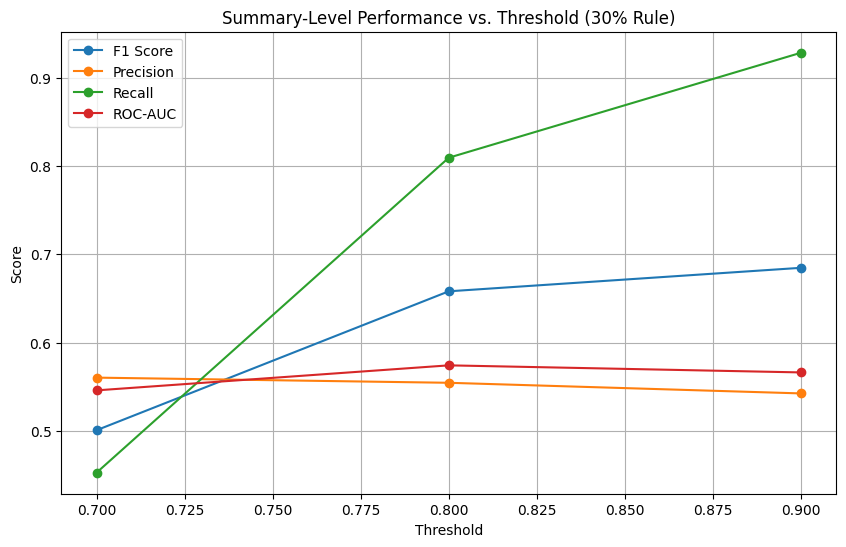

Best threshold: 0.90


In [118]:
# load embedding model
sim_model = SentenceTransformer("all-mpnet-base-v2")

# sentence-level evaluation
threshold = 0.6
sentence_df, y_true_sent, y_pred_sent = compute_sentence_level_labels(
    halu_df, sim_model, subset_size=1000, threshold=threshold
)

# summary-level evaluation
thresholds_values = [0.7, 0.8, 0.9]
f1_scores, precision_scores, recall_scores, roc_auc_scores = evaluate_summary_level(
    halu_df, sim_model, subset_size=1000, thresholds_values=thresholds_values, hallucination_fraction_threshold=0.5
)

# best threshold selection
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_values[best_idx]
print(f"Best threshold: {best_threshold:.2f}")

100it [00:11,  9.06it/s]


F1 Score: 0.6165
Precision: 0.4767
Recall: 0.8723
ROC-AUC: 0.5116
Confusion Matrix:
[[ 8 45]
 [ 6 41]]


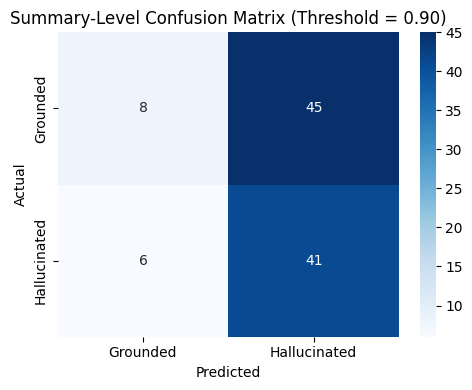

In [119]:
# final summary classification with best threshold
y_true, y_pred = [], []

for i, row in tqdm(halu_df.head(100).iterrows(), total=10):
    _, hallucinated_idx = detect_max_similarity(i, halu_df, sim_model, "summary", best_threshold)
    summary_sentences = sentence_splitting(row["summary"])
    fraction = len(hallucinated_idx) / len(summary_sentences)
    y_pred.append(1 if fraction > 0.6 else 0)
    y_true.append(row["is_hallucinated_summary"])

compute_and_plot_metrics(y_true, y_pred, title=f"Summary-Level Confusion Matrix (Threshold = {best_threshold:.2f})")

In [120]:
# classify and visualize sentence-level hallucinations
confident, possible, grounded = classify_hallucinations(
    sentence_df, confident_threshold=0.3, possible_threshold=0.5, min_word_count=6
)
pd.set_option("display.max_colwidth", None)
print("\nTop 5 Confident Hallucinations:")
display(confident.head(5))

print("\nTop 5 Possible Hallucinations:")
display(possible.head(5))

print("\nTop 5 Grounded Sentences:")
display(grounded.head(5))


Top 5 Confident Hallucinations:


,article_id,summary_sentence,similarity_score,most_similar_article_sentence,ground_truth_summary,is_hallucinated_summary,predicted_hallucination
100,37,The restart was delayed in March.,0.261431,"After problems that delayed the restart in March, scientists at the European Organization for Nuclear Research (CERN) completed final tests, enabling the first beams to start circulating Sunday inside the LHC's 17 mile (27 km) ring.",The Large Hadron Collider (LHC) begins again after a two-year shutdown. The restart was delayed in March.\n,0,1
237,85,"The park's large warehouses were severely impacted, but authorities are confident that production will continue as usual.",0.298407,"A mammoth fire broke out Friday morning in a Kentucky industrial park, sending plumes of thick smoke over the area as authorities worked to contain the damage.","Fire breaks out at the General Electric Appliance Park in Louisville, Kentucky. City official: No is believed to be injured or trapped.\n",1,1
798,288,Police say she is expected to survive.,0.286708,"Debra Lobo, a 55-year-old California native, was shot in the right cheek and left arm and is unconscious but expected to survive, according to Mohamad Shah, a Karachi police spokesman.","Debra Lobo, 55, is unconscious but is expected to survive after being shot Thursday, police say. She is vice principal of the Jinnah Medical and Dental College in Karachi. Police: She was on her way to pick up her daughters from school when she was shot.\n",1,1
1527,549,"However, the government has implemented strict policies to curb this trend.",0.278516,"Eritrea is ranked as one of the most repressive countries in the world, with an aging dictator enforcing a brutal regime of forced conscription to the army that rights groups believe is a cover for mass exploitation.","For 25 years, Ali Addeh refugee camp has been a holding point for those fleeing into Djibouti. Many come from Somalia, Ethiopia and especially Eritrea -- which is ruled by a one-party state. Despite the risks, Eritrean refugees say they'd risk their lives with people smugglers.\n",1,1



Top 5 Possible Hallucinations:


,article_id,summary_sentence,similarity_score,most_similar_article_sentence,ground_truth_summary,is_hallucinated_summary,predicted_hallucination
34,12,Tourists visiting California can expect to be greeted with free glasses of water at restaurants and lavish decorative fountains in residential areas.,0.442906,"So the next time you take a holiday in California, you'll find a few changes around here, thanks to the drought.","Americans paid more for some fruits and vegetables last year because of the drought. Tourists will now have to ask for a glass of water at a California restaurant. Perhaps the only good thing is another ""great"" wine grape harvest last year.\n",1,1
43,15,Police say this is not a criminal matter at this time.,0.473182,"There is no criminal investigation underway, he said.","Andrew Getty's death appears to be from natural causes, police say, citing coroner's early assessment. In a petition for a restraining order, Getty had written he had a serious medical condition. Police say this is not a criminal matter at this time.\n",0,1
69,25,An El Salvador man says he drifted from Mexico to Marshall Islands over a year.,0.491049,"""I thought I lost you."" Jose Salvador Alvarenga says his journey began in Paredon Viejo, a port on Mexico's Pacific coast, in late 2012.",A South Carolina man says he spent 66 days alone at sea before being rescued. Other sole survivor stories include a Japanese man washed away by a tsunami. An El Salvador man says he drifted from Mexico to Marshall Islands over a year.\n,0,1
115,41,Her attorneys are considering another appeal.,0.430174,The judge also denied a motion for visitation.,Judge won't allow teen leave hospital before her last chemotherapy treatment. Attorneys for the teen are deciding whether to appeal. Cassandra C. is now in remission and is no longer opposed to the chemotherapy treatments.\n,1,1
153,56,"Despite this setback, the network plans to move forward with the production of the remaining episodes under the guidance of a new director.",0.497788,"He said he felt the network was not offering enough money to produce the show ""the way it needed to be done."" Lynch also wrote that he had personally called the actors over the weekend to let them know he would no longer be directing.","David Lynch says he won't be directing new episodes of Twin Peaks. Showtime ""saddened"" over decision, which involved a dispute over money.\n",1,1



Top 5 Grounded Sentences:


,article_id,summary_sentence,similarity_score,most_similar_article_sentence,ground_truth_summary,is_hallucinated_summary,predicted_hallucination
0,0,"Marseille prosecutor says ""so far no videos were used in the crash investigation"" despite media reports.",1.0,,"Marseille prosecutor says ""so far no videos were used in the crash investigation"" despite media reports. Journalists at Bild and Paris Match are ""very confident"" the video clip is real, an editor says. Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says.\n",0,0
1,0,"Journalists at Bild and Paris Match are ""very confident"" the video clip is real, an editor says.",1.0,,"Marseille prosecutor says ""so far no videos were used in the crash investigation"" despite media reports. Journalists at Bild and Paris Match are ""very confident"" the video clip is real, an editor says. Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says.\n",0,0
2,0,"Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says.",1.0,,"Marseille prosecutor says ""so far no videos were used in the crash investigation"" despite media reports. Journalists at Bild and Paris Match are ""very confident"" the video clip is real, an editor says. Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says.\n",0,0
3,1,Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June.,1.0,,"Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June. Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis.\n",0,0
4,1,"Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis.",1.0,,"Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June. Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis.\n",0,0


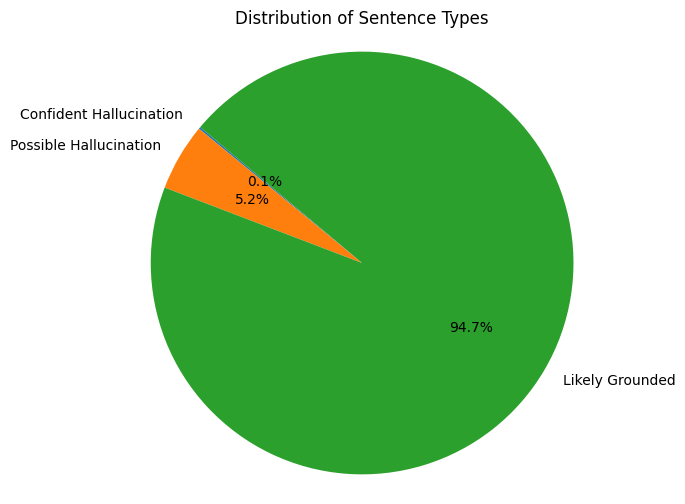

In [121]:
# plot distribution of classified sentence types
plot_hallucination_distribution(len(confident), len(possible), len(grounded))

## Sources

In [ ]:
'''@misc{HaluEval,
  author = {Junyi Li and Xiaoxue Cheng and Wayne Xin Zhao and Jian-Yun Nie and Ji-Rong Wen },
  title = {HaluEval: A Large-Scale Hallucination Evaluation Benchmark for Large Language Models},
  year = {2023},
  journal={arXiv preprint arXiv:2305.11747},
  url={https://arxiv.org/abs/2305.11747}
}'''

In [35]:
#torch.cuda.empty_cache()